In [56]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import numpy as np
# 변환 활성화
pandas2ri.activate()

def import_r_data():
    # 1) 필수 패키지 로드
    ro.r('library(haven)')
    # 2) R-side 데이터 로드
    ro.r('fish <- read_dta("http://www.stata-press.com/data/r11/fish.dta")')
    # 3) Python으로 변환
    fish_df = pandas2ri.rpy2py(ro.r('fish'))
    return fish_df

# 사용 예
fish = import_r_data()
print(type(fish))   # pandas.DataFrame
print(fish.head())

! curl package not installed, falling back to using `url()`
<class 'pandas.core.frame.DataFrame'>
   nofish  livebait  camper  persons  child        xb        zg  count
1     1.0       0.0     0.0      1.0    0.0 -0.896315  3.050405    0.0
2     0.0       1.0     1.0      1.0    0.0 -0.558345  1.746149    0.0
3     0.0       1.0     0.0      1.0    0.0 -0.401731  0.279939    0.0
4     0.0       1.0     1.0      2.0    1.0 -0.956298 -0.601526    0.0
5     0.0       1.0     0.0      1.0    0.0  0.436891  0.527709    1.0


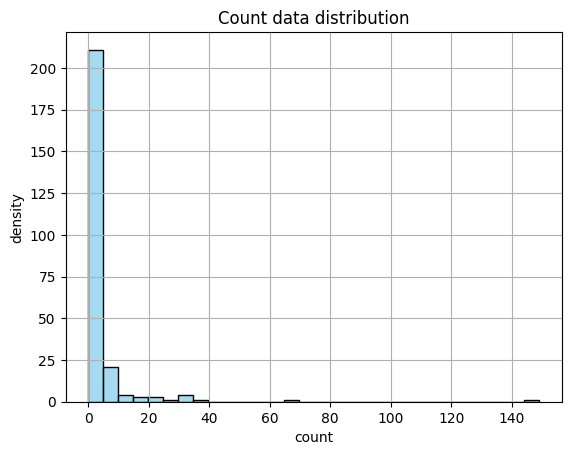

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(fish["count"], bins=30, color='skyblue')
plt.title("Count data distribution")
plt.xlabel("count")
plt.ylabel("density")
plt.grid(True)
plt.show()

In [58]:
import statsmodels.api as sm
import pandas as pd

# 설명 변수
exog = fish[["camper", "persons"]]  # 포아송 부분
exog = sm.add_constant(exog)        # 상수항 추가

# 제로 인플레이션 모델용 설명 변수
exog_infl = fish[["camper", "persons"]]
exog_infl = sm.add_constant(exog_infl)

# 종속변수
endog = fish["count"]

# ZIP 모델 적합
model = sm.ZeroInflatedPoisson(endog, exog, exog_infl=exog_infl, inflation='logit')
result = model.fit()

# 결과 출력
print(result.summary())


Optimization terminated successfully.
         Current function value: 3.590314
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                   count   No. Observations:                  250
Model:             ZeroInflatedPoisson   Df Residuals:                      247
Method:                            MLE   Df Model:                            2
Date:                 Thu, 29 May 2025   Pseudo R-squ.:                  0.2036
Time:                         14:07:52   Log-Likelihood:                -897.58
converged:                        True   LL-Null:                       -1127.0
Covariance Type:             nonrobust   LLR p-value:                2.257e-100
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
inflate_const       

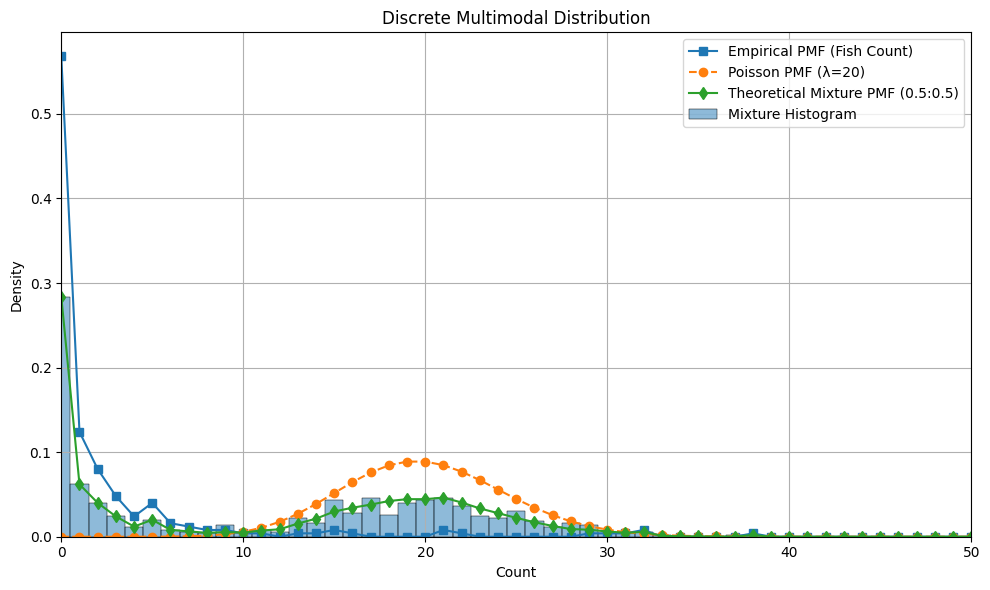

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

# 1. 실측 데이터 (정수형으로 변환)
fish_count = fish["count"].values
fish_count_int = fish_count.astype(int)
lambda_hat = 20

# 2. 포아송 기반 샘플 생성
n = len(fish_count_int)
poisson_sample = np.random.poisson(lam=lambda_hat, size=n)

# 3. 멀티모달 샘플 구성
multimodal_samples = np.concatenate([fish_count_int, poisson_sample])

# 4. x 축: 최소값부터 50까지
x_min = multimodal_samples.min()
x_max = 50
x = np.arange(x_min, x_max + 1)

# 5. 경험적 PMF (0~50 범위)
counts = np.bincount(fish_count_int, minlength=x_max + 1)
emp_pmf = counts[x] / n

# 6. 포아송 이론 PMF (0~50 범위)
pois_pmf = poisson.pmf(x, mu=lambda_hat)

# 7. 이론적 혼합 PMF (0.5:0.5)
w = 0.5
mix_pmf = w * emp_pmf + (1 - w) * pois_pmf

# 8. 시각화
plt.figure(figsize=(10, 6))

# — 혼합 이산 히스토그램
sns.histplot(
    multimodal_samples,
    bins=x,
    stat="density",
    discrete=True,
    element="bars",
    alpha=0.5,
    label="Mixture Histogram"
)

# — 경험적 PMF
plt.plot(x, emp_pmf, 's-', label="Empirical PMF (Fish Count)")

# — 포아송 PMF
plt.plot(x, pois_pmf, 'o--', label=f"Poisson PMF (λ={lambda_hat})")

# — 이론적 혼합 PMF
plt.plot(x, mix_pmf, 'd-', label="Theoretical Mixture PMF (0.5:0.5)")

# — x축을 [x_min, 50]으로 제한
plt.xlim(x_min, x_max)

plt.title("Discrete Multimodal Distribution")
plt.xlabel("Count")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [60]:
from statsmodels.discrete.count_model import ZeroInflatedPoisson
import statsmodels.api as sm

# 멀티모달 count (예: 500개짜리)
y = multimodal_samples  # 혹은 count

# 설명변수 없이 → 상수열 사용 (모든 관측치가 동일한 intercept만 가지는 형태)
X = np.ones((len(y), 1))  # <- exog와 exog_infl 모두 상수항만 포함

zip_model = ZeroInflatedPoisson(endog=y, exog=X, exog_infl=X, inflation='logit')
result = zip_model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 4.831839
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                       y   No. Observations:                  500
Model:             ZeroInflatedPoisson   Df Residuals:                      499
Method:                            MLE   Df Model:                            0
Date:                 Thu, 29 May 2025   Pseudo R-squ.:               1.255e-11
Time:                         14:07:52   Log-Likelihood:                -2415.9
converged:                        True   LL-Null:                       -2415.9
Covariance Type:             nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -0.9247   

Optimization terminated successfully.
         Current function value: 5.915013
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21


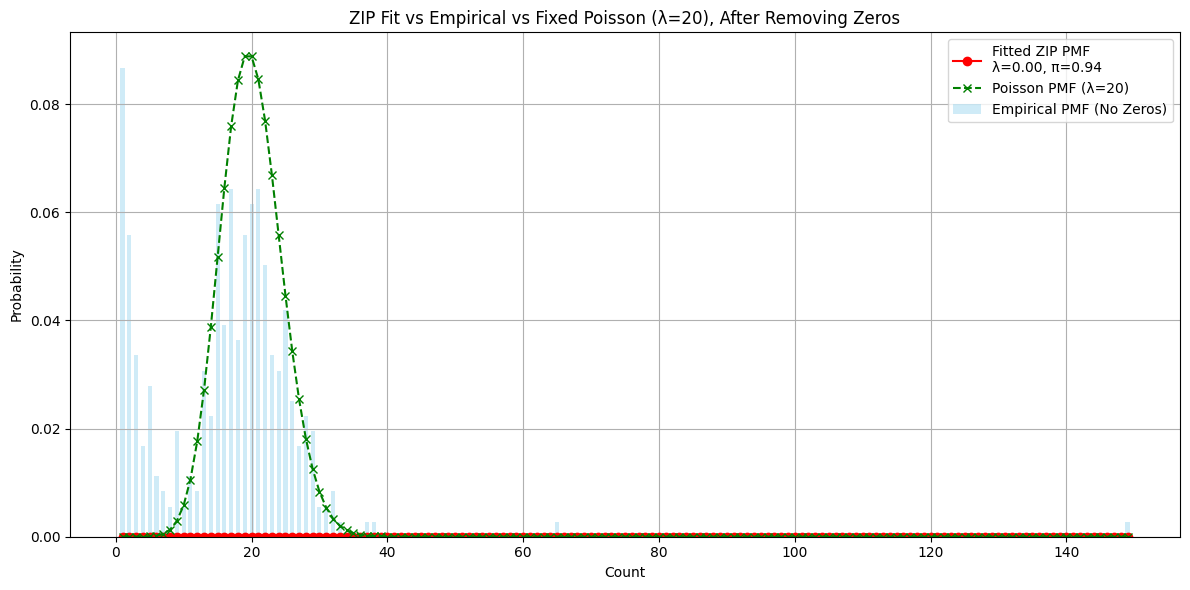

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from statsmodels.discrete.count_model import ZeroInflatedPoisson
import statsmodels.api as sm

# 1. 멀티모달 count 데이터에서 0 제거
y = multimodal_samples.astype(int)
y = y[y > 0]

# 2. ZIP 모델 적합 (설명변수 없이 상수만)
X_const = np.ones((len(y), 1))
zip_model = ZeroInflatedPoisson(endog=y, exog=X_const, exog_infl=X_const, inflation='logit')
result = zip_model.fit()

# 3. 추정된 ZIP 파라미터
lambda_hat = np.exp(result.params[0])  # 학습된 λ
pi_hat = 1 / (1 + np.exp(-result.params[-1]))  # 학습된 π

# 4. x 축 범위
x = np.arange(1, np.max(y) + 1)

# 5. ZIP PMF (0 제외)
zip_pmf = (1 - pi_hat) * poisson.pmf(x, lambda_hat)

# 6. 경험적 PMF
counts = np.bincount(y, minlength=x.max() + 1)
empirical_pmf = counts[x] / len(y)

# 7. 고정된 포아송(λ=20) PMF
poisson_fixed_lambda = 20
poisson_pmf_fixed = poisson.pmf(x, mu=poisson_fixed_lambda)

# 8. 시각화
plt.figure(figsize=(12, 6))

plt.bar(x, empirical_pmf, width=0.6, alpha=0.4, label="Empirical PMF (No Zeros)", color='skyblue')
plt.plot(x, zip_pmf, 'o-', color='red', label=f"Fitted ZIP PMF\nλ={lambda_hat:.2f}, π={pi_hat:.2f}")
plt.plot(x, poisson_pmf_fixed, 'x--', color='green', label="Poisson PMF (λ=20)")

plt.title("ZIP Fit vs Empirical vs Fixed Poisson (λ=20), After Removing Zeros")
plt.xlabel("Count")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


   Degree     Lambda                        Alpha       LogLik          AIC  \
0       1  16.470093                      [0.001] -2112.623941  4229.247883   
1       2  15.891381              [0.0, 0.001646] -2099.996805  4205.993610   
2       3  15.226357         [0.0, 0.0, 0.000189] -2072.616245  4153.232490   
3       4  14.576532     [0.0, 0.0, 0.0, 1.7e-05] -2039.638036  4089.276071   
4       5  13.958294  [0.0, 0.0, 0.0, 0.0, 1e-06] -2005.049924  4022.099847   

           BIC  
0  4237.008949  
1  4217.635209  
2  4168.754622  
3  4108.678736  
4  4045.383045  


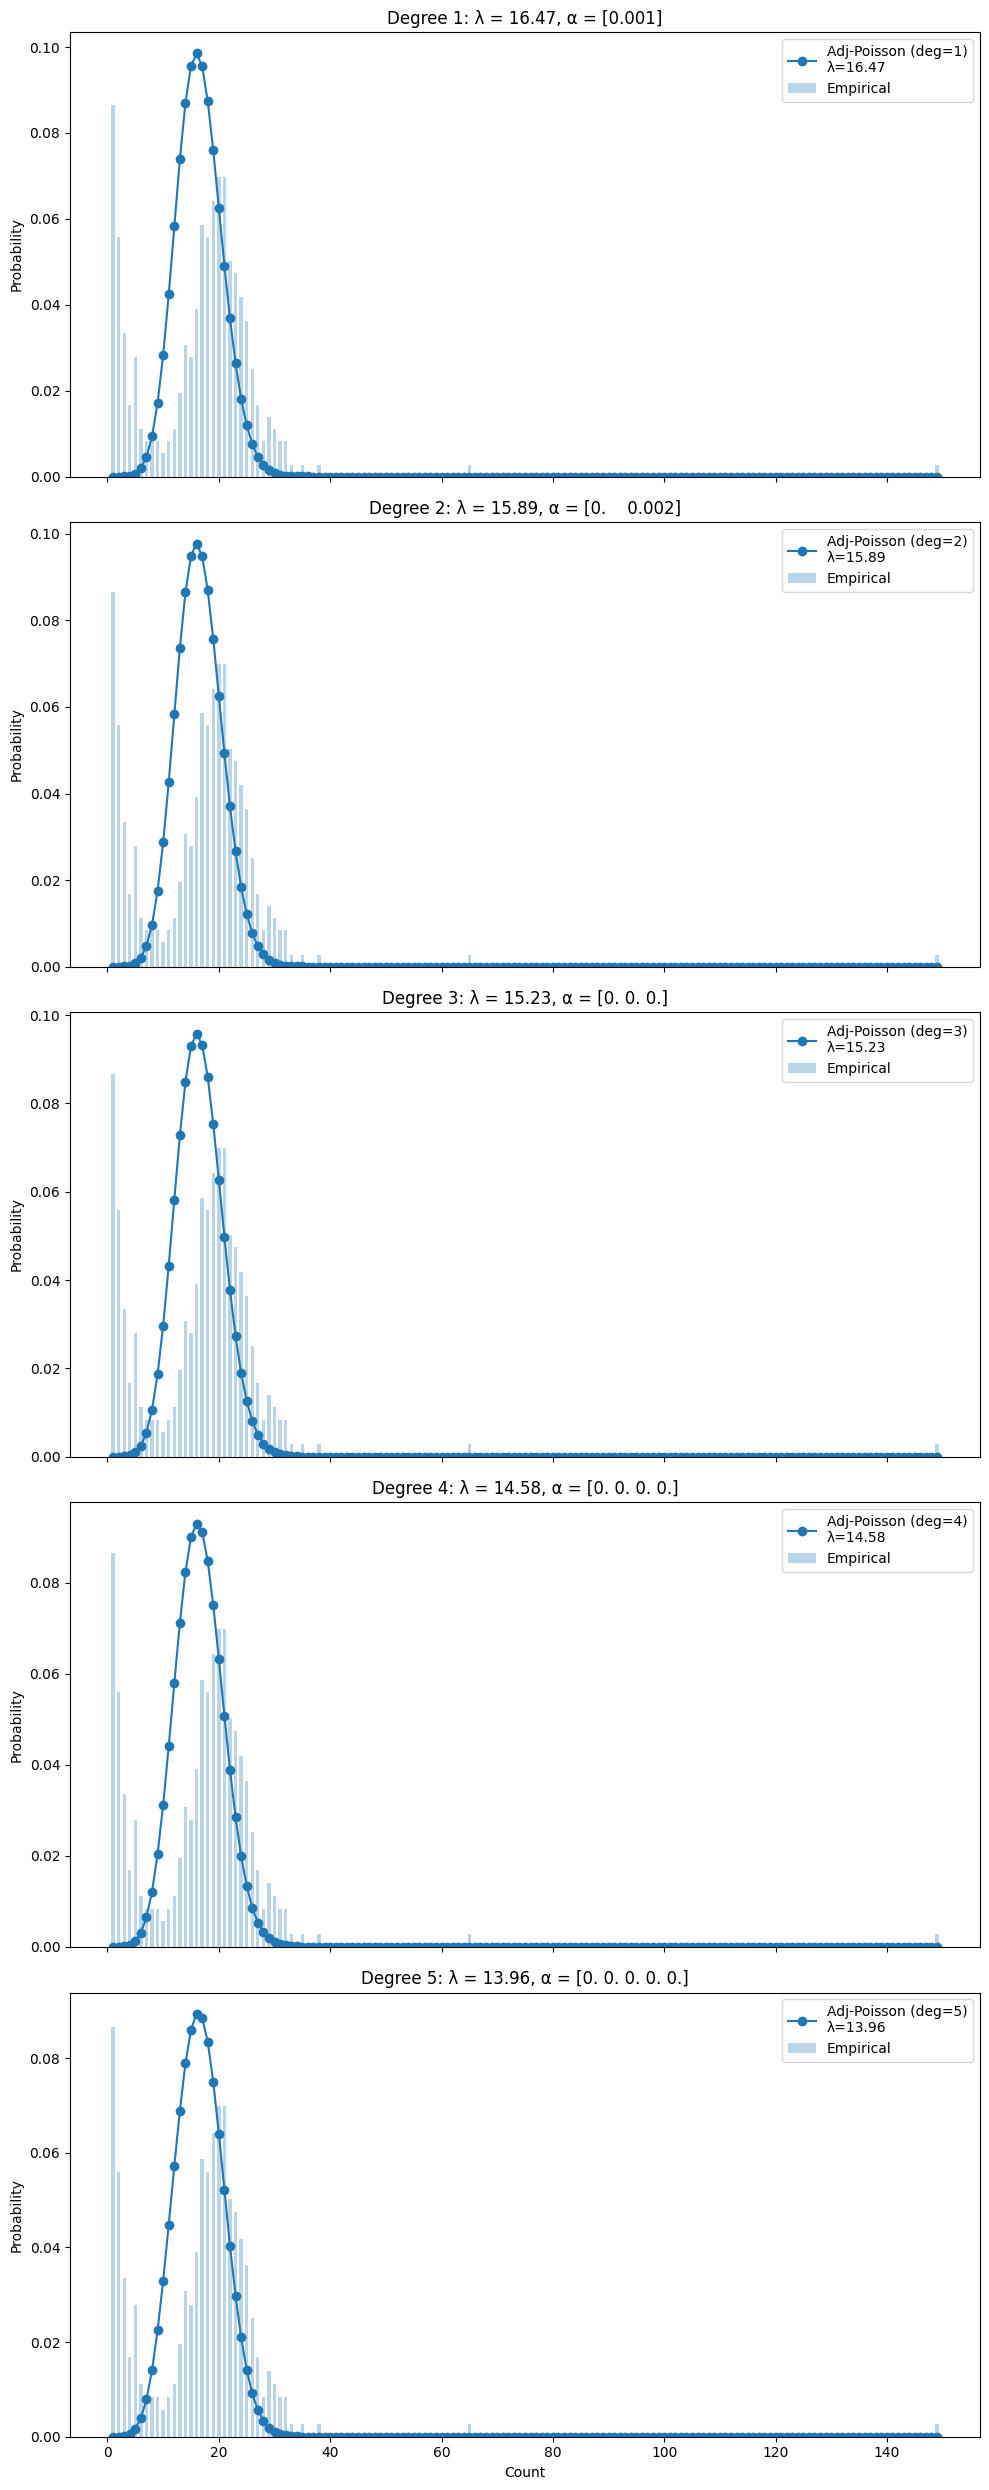

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.special import gammaln
from scipy.optimize import minimize
import pandas as pd

# 데이터 준비: 0 제거
fish_count = fish["count"].values.astype(int)
lambda_hat = 20
poisson_sample = np.random.poisson(lam=lambda_hat, size=len(fish_count))
multimodal_samples = np.concatenate([fish_count, poisson_sample])

y_all = multimodal_samples.astype(int)
y = y_all[y_all > 0]
n = len(y)
counts = np.bincount(y, minlength=y.max()+1)
emp_pmf = counts[1:] / n
x = np.arange(1, y.max()+1)

# 다항 차수별 분석
results = []
degrees = [1, 2, 3, 4, 5]
fig, axes = plt.subplots(len(degrees), 1, figsize=(10, 5 * len(degrees)), sharex=True)

for idx, degree in enumerate(degrees):
    def T(y, alpha):
        y = np.atleast_1d(y)
        powers = np.arange(degree + 1)
        alpha_full = np.concatenate([[1], alpha])
        return np.sum(alpha_full * y[:, None]**powers, axis=1)

    def Z(lam, alpha):
        powers = np.arange(degree + 1)
        alpha_full = np.concatenate([[1], alpha])
        return np.sum([
            alpha_full[j] * poisson.moment(j, lam)
            for j in powers
        ])

    def neg_loglike(params):
        loglam = params[0]
        eta = params[1:]
        lam = np.exp(loglam)
        alpha = np.exp(eta)
        Zval = Z(lam, alpha)
        ll = (
            -lam * n
            + np.sum(y) * loglam
            - np.sum(gammaln(y+1))
            + np.sum(np.log(T(y, alpha)))
            - n * np.log(Zval)
        )
        return -ll

    init_loglam = np.log(np.mean(y))
    init_eta = np.log([1e-3] * degree)
    init_params = np.concatenate([[init_loglam], init_eta])

    res = minimize(
        neg_loglike,
        init_params,
        method="L-BFGS-B",
        options={"maxiter": 500, "disp": False}
    )

    loglam_hat = res.x[0]
    eta_hat = res.x[1:]
    lam_hat = np.exp(loglam_hat)
    alpha_hat = np.exp(eta_hat)
    adj_pmf = poisson.pmf(x, lam_hat) * T(x, alpha_hat) / Z(lam_hat, alpha_hat)

    k = 1 + degree  # logλ + α_j들
    logL = -res.fun
    AIC = 2 * k - 2 * logL
    BIC = k * np.log(n) - 2 * logL

    results.append({
        "Degree": degree,
        "Lambda": lam_hat,
        "Alpha": alpha_hat.round(6),
        "LogLik": logL,
        "AIC": AIC,
        "BIC": BIC
    })

    ax = axes[idx]
    ax.bar(x, emp_pmf, width=0.6, alpha=0.3, label="Empirical")
    ax.plot(x, adj_pmf, 'o-', label=f"Adj-Poisson (deg={degree})\nλ={lam_hat:.2f}")
    ax.legend()
    ax.set_ylabel("Probability")
    ax.set_title(f"Degree {degree}: λ = {lam_hat:.2f}, α = {alpha_hat.round(3)}")

axes[-1].set_xlabel("Count")
plt.tight_layout()

summary_df = pd.DataFrame(results)
# 요약 테이블
print(summary_df)

Estimated λ = 14.579
Estimated α (1~4) = [0.0e+00 0.0e+00 0.0e+00 1.7e-05]


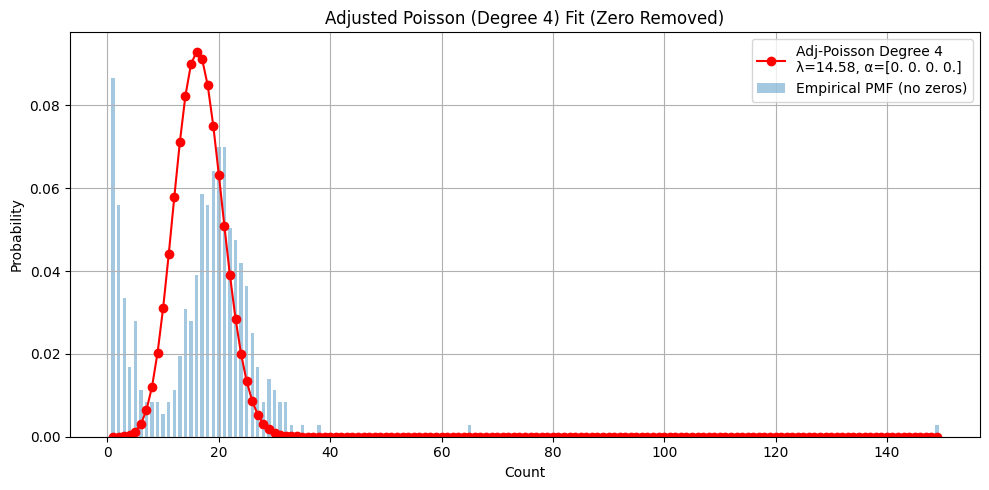

In [63]:
# 1) 데이터 준비: 0 제거
y_all = multimodal_samples.astype(int)
y = y_all[y_all > 0]
n = len(y)

# 2) 모델 정의
#   T(y; α) = Σ_{j=0..degree} α_j * y^j, 단 α_0 = 1 고정
def T(y, alpha):
    powers = np.arange(degree + 1)
    # alpha는 length degree (α_1...α_degree), α_0는 1
    alpha_full = np.concatenate([[1], alpha])
    return np.sum(alpha_full * y[:, None]**powers, axis=1)

#   Z(λ, α) = Σ_{m=0..m_max} Poisson(m;λ) * T(m;α)
def Z(lam, alpha, m_max=100):
    m = np.arange(0, m_max + 1)
    alpha_full = np.concatenate([[1], alpha])
    powers = np.arange(degree + 1)
    Tm = np.sum(alpha_full * m[:, None]**powers, axis=1)
    pmf_m = poisson.pmf(m, lam)
    return np.sum(pmf_m * Tm)

# 3) 음의 로그우도 함수
def neg_loglike(params):
    loglam = params[0]
    eta = params[1:]
    lam = np.exp(loglam)
    alpha = np.exp(eta)  # α_j ≥ 0 보장
    Zval = Z(lam, alpha, m_max=int(lam + 5*np.sqrt(lam)))
    
    # log PMF 계산
    ll = (
        -lam * n
        + np.sum(y) * loglam
        - np.sum(gammaln(y + 1))
        + np.sum(np.log(T(y, alpha)))
        - n * np.log(Zval)
    )
    return -ll

# 4) 초기값 설정
degree=4
init_loglam = np.log(np.mean(y))
init_eta = np.log([1e-3] * degree)
init_params = np.concatenate([[init_loglam], init_eta])

# 5) 최적화
res = minimize(
    neg_loglike,
    init_params,
    method="L-BFGS-B",
    options={"maxiter": 500, "disp": True}
)

# 6) 추정치 해석
lam_hat = np.exp(res.x[0])
alpha_hat = np.exp(res.x[1:])
print(f"Estimated λ = {lam_hat:.3f}")
print(f"Estimated α (1~{degree}) = {alpha_hat.round(6)}")

# 7) 시각화
x = np.arange(1, y.max() + 1)
counts = np.bincount(y, minlength=x.max() + 1)
emp_pmf = counts[x] / n
adj_pmf = poisson.pmf(x, lam_hat) * T(x, alpha_hat) / Z(lam_hat, alpha_hat, m_max=int(lam_hat + 5*np.sqrt(lam_hat)))

plt.figure(figsize=(10, 5))
plt.bar(x, emp_pmf, width=0.6, alpha=0.4, label="Empirical PMF (no zeros)")
plt.plot(
    x, adj_pmf, 'o-', color='red',
    label=f"Adj-Poisson Degree {degree}\nλ={lam_hat:.2f}, α={alpha_hat.round(3)}"
)
plt.title(f"Adjusted Poisson (Degree {degree}) Fit (Zero Removed)")
plt.xlabel("Count")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Fixed λ = 15.0
Estimated α (1~3) = [0.       0.       0.000214]


/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_62201/164918394.py:84: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/7n/zyzjp7wj0cn68mx_s16mw1m00000gn/T/ipykernel_62201/164918394.py:84: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/ijongseung/powerdemand-prediction/hybrid1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ijongseung/powerdemand-prediction/hybrid1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


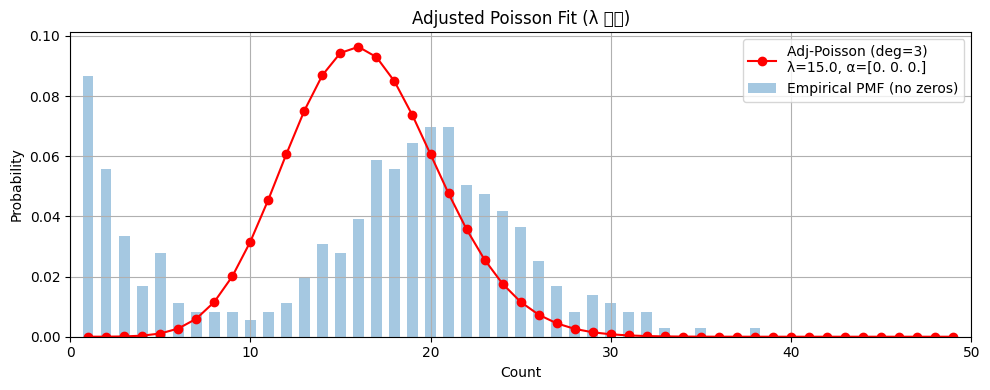

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.special import gammaln
from scipy.optimize import minimize

# ——————————————————————————————
# 0) 파라미터 설정
degree = 3              # 보정 다항 차수
lam_fixed = 15.0          # λ를 고정 (예: 이전에 추정된 λ 값)
# ——————————————————————————————

# 1) 데이터 준비 (0 제거)
y_all = multimodal_samples.astype(int)
y = y_all[y_all > 0]
n = len(y)

# 2) 보정 함수 T(y;α)
def T(y, alpha):
    """
    y: array of counts
    alpha: 1D array length=degree (α1...α_degree)
    returns: T(y) = 1 + α1*y + ... + α_degree*y^degree
    """
    powers = np.arange(degree + 1)                # [0,1,...,degree]
    alpha_full = np.concatenate([[1], alpha])     # α0=1 고정
    return np.sum(alpha_full * y[:,None]**powers, axis=1)

# 3) 정규화 상수 Z(λ_fixed,α)
def Z(alpha, m_max=100):
    m = np.arange(0, m_max+1)
    powers = np.arange(degree + 1)
    alpha_full = np.concatenate([[1], alpha])
    Tm = np.sum(alpha_full * m[:,None]**powers, axis=1)
    pmf_m = poisson.pmf(m, lam_fixed)
    return np.sum(pmf_m * Tm)

# 4) α만을 위한 음의 로그우도 함수 (logλ 생략)
def neg_loglike_alpha(params):
    # params = [η1, η2, ..., η_degree], α_j = exp(η_j) ≥ 0
    alpha = np.exp(params)
    Zval = Z(alpha, m_max=int(lam_fixed + 5*np.sqrt(lam_fixed)))
    # log PMF 반복 합산
    ll = (
        -lam_fixed * n
        + np.sum(y) * np.log(lam_fixed)
        - np.sum(gammaln(y+1))
        + np.sum(np.log(T(y, alpha)))
        - n * np.log(Zval)
    )
    return -ll

# 5) 초기값 (작은 positive)
init_eta = np.log([1e-3]*degree)
res = minimize(
    neg_loglike_alpha,
    init_eta,
    method="L-BFGS-B",
    options={"maxiter":500, "disp":True}
)

# 6) 추정된 α 해석
eta_hat   = res.x
alpha_hat = np.exp(eta_hat)
print(f"Fixed λ = {lam_fixed}")
print(f"Estimated α (1~{degree}) = {alpha_hat.round(6)}")

# 7) 시각화: Empirical vs Adjusted-Poisson
x = np.arange(1, min(50, y.max()+1))
counts = np.bincount(y, minlength=x.max()+1)
emp_pmf = counts[x] / n
adj_pmf = poisson.pmf(x, lam_fixed) * T(x, alpha_hat) / Z(alpha_hat)

plt.figure(figsize=(10,4))
plt.bar(x, emp_pmf, width=0.6, alpha=0.4, label="Empirical PMF (no zeros)")
plt.plot(x, adj_pmf, 'o-', color='red',
         label=f"Adj-Poisson (deg={degree})\nλ={lam_fixed}, α={alpha_hat.round(3)}")
plt.xlim(0, 50)
plt.xlabel("Count")
plt.ylabel("Probability")
plt.title("Adjusted Poisson Fit (λ 고정)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [65]:
fish

,nofish,livebait,camper,persons,child,xb,zg,count
1,1.0,0.0,0.0,1.0,0.0,-0.896315,3.050405,0.0
2,0.0,1.0,1.0,1.0,0.0,-0.558345,1.746149,0.0
3,0.0,1.0,0.0,1.0,0.0,-0.401731,0.279939,0.0
4,0.0,1.0,1.0,2.0,1.0,-0.956298,-0.601526,0.0
5,0.0,1.0,0.0,1.0,0.0,0.436891,0.527709,1.0
...,...,...,...,...,...,...,...,...
246,1.0,1.0,1.0,2.0,0.0,-0.755236,2.324209,0.0
247,0.0,1.0,1.0,4.0,3.0,1.794859,-5.625944,0.0
248,0.0,1.0,1.0,2.0,1.0,-0.392649,0.677275,0.0
249,1.0,1.0,1.0,3.0,2.0,1.374641,-2.595630,0.0


In [66]:
y_all = multimodal_samples.astype(int)
fish_data = fish[fish["count"]>0]

n = len(y)

# covariates for α 조정 (예: fisher[["persons","camper"]] 등)
W = fish_data[["persons", "camper"]].values  # shape (n, p)
p = W.shape[1]

degree = 3  # cubic adjuster
# --- 1) T_i(y; δ) 정의 ---
def T_i(y_i, deltas):
    # deltas: length p×degree vector,  
    #   reshape to (degree, p) so that δ_j is deltas[j]
    delta = deltas.reshape(degree, p)
    # α_{0,i} ≡ 1
    T = np.ones_like(y_i, dtype=float)
    for j in range(1, degree+1):
        # compute α_{j,i} = exp( W · δ_j )
        alpha_ji = np.exp(W.dot(delta[j-1]))
        T += alpha_ji * (y_i**j)
    return T

# --- 2) normalizing constant Z_i(λ_i, δ) ---
def Z_i(lam, deltas, m_max=100):
    delta = deltas.reshape(degree, p)
    m = np.arange(0, m_max+1)
    # T_i for all m
    Tm = np.ones((m_max+1,))
    for j in range(1, degree+1):
        alpha_ji = np.exp(W.dot(delta[j-1]))     # but W is per-observation; for global Z we can use mean W or truncate per-i
        # **실제 ZIPAP에선 Z_i을 관측치별로 계산**
        Tm += alpha_ji.mean() * (m**j)           # (단순 예시: 평균화)
    return np.sum(poisson.pmf(m, lam) * Tm)

# --- 3) 음의 로그우도 (zero-inflation 제외한 AP-only 부분) ---
def neg_loglike_all(params):
    # params = [loglam, [β(포아송), γ(zero), δ(α조정)]...]
    loglam = params[0]
    lam = np.exp(loglam)
    deltas = params[1:]  # length = p * degree

    # log-likelihood sum over y
    Tvals = T_i(y, deltas)
    Zvals = Z_i(lam, deltas, m_max=int(lam+5*np.sqrt(lam)))
    ll = (
        -lam * n
        + np.sum(y)*loglam
        - np.sum(gammaln(y+1))
        + np.sum(np.log(Tvals))
        - n * np.log(Zvals)
    )
    return -ll

# --- 4) 초기값 및 최적화 ---
init_loglam = np.log(np.mean(y))
init_deltas = np.zeros(p*degree)  # δ_j 초기값 모두 0
init_params = np.concatenate([[init_loglam], init_deltas])

res = minimize(
    neg_loglike_all,
    init_params,
    method="L-BFGS-B",
    options={"disp":True}
)

# --- 5) 결과 해석 ---
lam_hat = np.exp(res.x[0])
delta_hat = res.x[1:].reshape(degree, p)
alpha_hat = np.exp(W.dot(delta_hat.T))  # shape (n, degree)

print("Fixed λ =", lam_hat)
print("Estimated δ_j for each covariate:\n", delta_hat)

ValueError: operands could not be broadcast together with shapes (108,) (358,) 

최종 추정된 혼합비: [0.44708791 0.55291209]
최종 추정된 λ 들: [ 0.88012837 20.58284742]


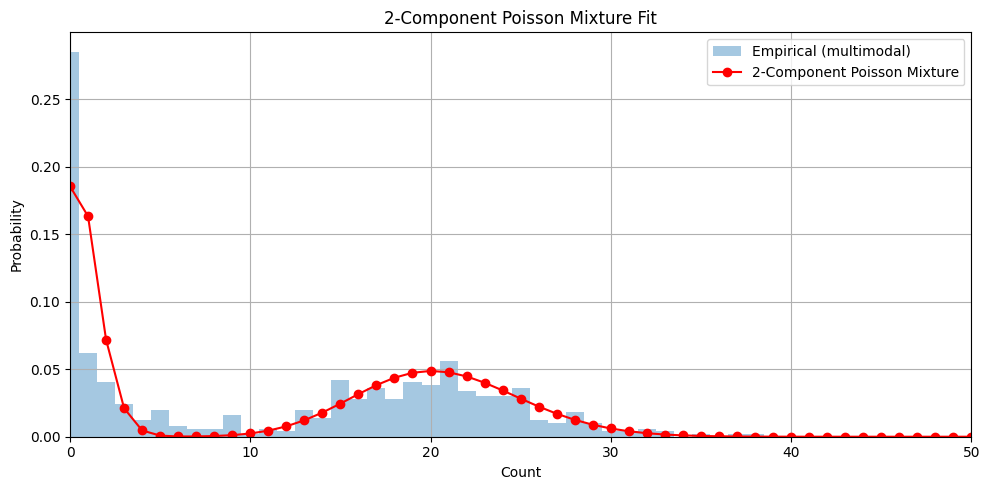

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# 1) 멀티모달 샘플 준비 (실측 + Poisson 샘플 합친 y_all)
# multimodal_samples 변수가 이미 있으면 그대로 쓰고, 없으면 재구성하세요.
# 예시 재구성:
# fish_count = fish["count"].values.astype(int)
# poisson_sample = np.random.poisson(lam=20, size=len(fish_count))
# y_all = np.concatenate([fish_count, poisson_sample]).astype(int)

y_all = multimodal_samples.astype(int)  # ← 본인 환경에 맞게

# 2) EM 설정
K = 2  # 두 개 성분
weights = np.full(K, 1/K)             # 초기 혼합비
lambdas = np.array([5.0, 25.0])       # 초기 λ 추정값

# 3) EM 반복
for it in range(100):
    # E-step: 책임도 계산
    resp = np.vstack([weights[k] * poisson.pmf(y_all, lambdas[k]) 
                      for k in range(K)]).T
    resp /= resp.sum(axis=1, keepdims=True)

    # M-step: weights와 lambdas 업데이트
    weights = resp.mean(axis=0)
    lambdas = (resp * y_all[:,None]).sum(axis=0) / resp.sum(axis=0)

print("최종 추정된 혼합비:", weights)
print("최종 추정된 λ 들:", lambdas)

# 4) 혼합 PMF 그리기
x = np.arange(0, 51)
mixture_pmf = sum(weights[k] * poisson.pmf(x, lambdas[k]) for k in range(K))

plt.figure(figsize=(10,5))
plt.hist(y_all, bins=np.arange(52)-0.5, density=True, alpha=0.4, label="Empirical (multimodal)")
plt.plot(x, mixture_pmf, 'o-', color='red', label="2-Component Poisson Mixture")
plt.xlim(0, 50)
plt.xlabel("Count")
plt.ylabel("Probability")
plt.title("2-Component Poisson Mixture Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




Estimated π = 0.284
Estimated λ = 16.392
Estimated α = [0.000103]


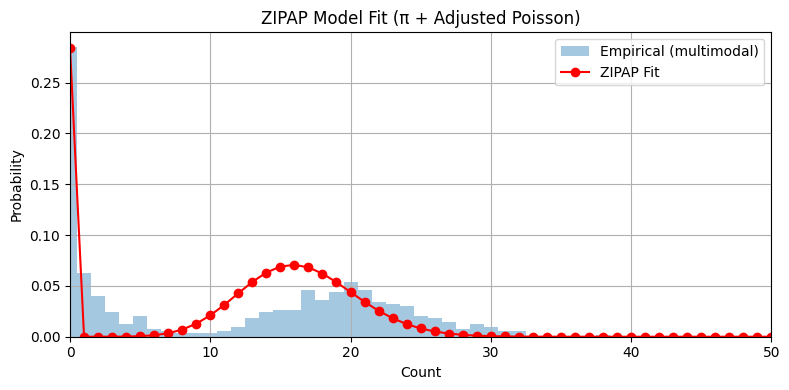

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.special import gammaln
from scipy.optimize import minimize

# 0) fish DataFrame 로드 (제로 포함 원본)
# import pandas as pd
# fish = pd.read_csv("path_to_full_fish_data.csv")

# 1) multimodal 샘플 구성
fish_count     = fish["count"].astype(int).values
poisson_sample = np.random.poisson(lam=20, size=len(fish_count))
multimodal_samples = np.concatenate([fish_count, poisson_sample])

# 2) 데이터 분리
y_all  = multimodal_samples
y_pos  = y_all[y_all > 0]
n_zero = np.sum(y_all == 0)
n_pos  = len(y_pos)

# 3) 다항 보정 차수 설정
degree = 1  # 필요에 따라 3,4차로 올릴 수 있음

# 4) T(y)와 정규화 상수 Z 정의
def T(y, alpha):
    return 1 + sum(alpha[j] * (y ** (j + 1)) for j in range(degree))

def Z(lam, alpha, m_max=100):
    m = np.arange(m_max + 1)
    Tm = 1 + sum(alpha[j] * (m ** (j + 1)) for j in range(degree))
    return np.sum(poisson.pmf(m, lam) * Tm)

# 5) ZIPAP 음의 로그우도 (π, λ, α 동시 추정)
def neg_ll_zipap(params):
    logit_pi, loglam, *eta = params
    # 5.1) 파라미터 복원
    pi    = 1 / (1 + np.exp(-logit_pi))
    lam   = np.exp(loglam)
    alpha = np.exp(eta)
    # 5.2) 정규화
    Zval  = Z(lam, alpha, m_max=int(lam + 5*np.sqrt(lam)))
    f0    = np.exp(-lam) / Zval  # AP density at 0
    # 5.3) 0일 때 로그우도
    ll0   = n_zero * np.log(pi + (1 - pi) * f0)
    # 5.4) 양수일 때 로그우도
    const = np.log(1 - pi)
    ll_pos = 0
    for y in y_pos:
        ll_pos += (
            const
            + (-lam + y * loglam - gammaln(y + 1))
            + np.log(T(y, alpha))
            - np.log(Zval)
        )
    return -(ll0 + ll_pos)

# 6) 초기값 설정
init_pi     = np.log(n_zero / len(y_all) / (1 - n_zero / len(y_all)))
init_loglam = np.log(np.mean(y_pos))
init_eta    = np.log([1e-2] * degree)
init_params = np.concatenate([[init_pi, init_loglam], init_eta])

# 7) 최적화
res = minimize(
    neg_ll_zipap,
    init_params,
    method="L-BFGS-B",
    options={"maxiter": 500, "disp": True}
)

# 8) 추정 결과 복원
logit_pi, loglam, *eta = res.x
pi_hat    = 1 / (1 + np.exp(-logit_pi))
lam_hat   = np.exp(loglam)
alpha_hat = np.exp(eta)

print(f"Estimated π = {pi_hat:.3f}")
print(f"Estimated λ = {lam_hat:.3f}")
print(f"Estimated α = {alpha_hat.round(6)}")

# 9) ZIPAP PMF 계산 및 시각화
x   = np.arange(0, 51)
pmf = np.zeros_like(x, dtype=float)
Zval = Z(lam_hat, alpha_hat, m_max=int(lam_hat + 5*np.sqrt(lam_hat)))
# P(Y=0)
pmf[0] = pi_hat + (1 - pi_hat) * (np.exp(-lam_hat) / Zval)
# P(Y>0)
Tm      = 1 + sum(alpha_hat[j] * (x[1:] ** (j + 1)) for j in range(degree))
pmf[1:] = (1 - pi_hat) * poisson.pmf(x[1:], lam_hat) * Tm / Zval

plt.figure(figsize=(8,4))
plt.hist(y_all, bins=np.arange(x.max()+2)-0.5, density=True,
         alpha=0.4, label="Empirical (multimodal)")
plt.plot(x, pmf, 'o-', color='red', label="ZIPAP Fit")
plt.xlim(0, 50)
plt.xlabel("Count")
plt.ylabel("Probability")
plt.title("ZIPAP Model Fit (π + Adjusted Poisson)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Component 1: λ = 0.852, weight = 0.445
Component 2: λ = 19.628, weight = 0.551
Component 3: λ = 106.998, weight = 0.004


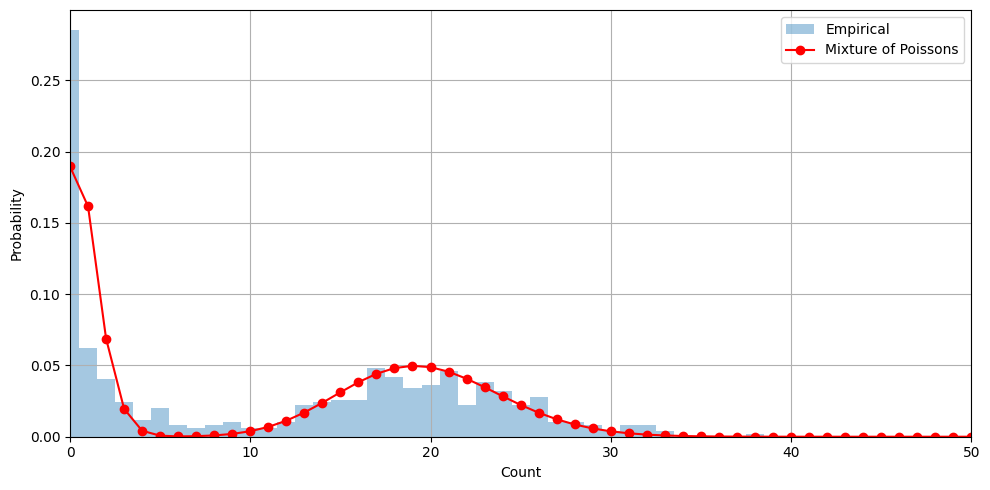

In [ ]:
## 혼합분포에 붙이기
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.special import gammaln
from scipy.optimize import minimize

# 0) 데이터 준비
fish_count     = fish["count"].values.astype(int)
poisson_sample = np.random.poisson(lam=20, size=len(fish_count))
y_all          = np.concatenate([fish_count, poisson_sample]).astype(int)

# 1) 하이퍼파라미터
K = 3   # mixture component 수

# 2) 초기 파라미터 (log λ_k, 그리고 mixture logits)
init_loglams = np.log(np.linspace(5.0, 20.0, K))
init_logits  = np.zeros(K)
init_params  = np.concatenate([init_loglams, init_logits])

# 3) Negative log-likelihood 정의 (Mixture of plain Poissons)
def neg_loglike_mixPois(params):
    loglams    = params[:K]
    lams       = np.exp(loglams)            # λ_k
    mix_logits = params[K:]
    w_raw      = np.exp(mix_logits - np.max(mix_logits))
    weights    = w_raw / w_raw.sum()        # mixture weights

    # 전체 관측치 y에 대한 log-likelihood 합산
    ll = 0.0
    for y in y_all:
        # k별 log P_Poisson(y; λ_k) + log w_k
        comp = (
            -lams
            + y * np.log(lams)
            - gammaln(y + 1)
            + np.log(weights)
        )
        # mixture logsumexp
        ll += np.logaddexp.reduce(comp)
    return -ll

# 4) 최적화
res = minimize(
    neg_loglike_mixPois,
    init_params,
    method="L-BFGS-B",
    options={"disp": True, "maxiter": 200}
)

# 5) 결과 추출
loglams    = res.x[:K]
lams       = np.exp(loglams)
mix_logits = res.x[K:]
w_raw      = np.exp(mix_logits - np.max(mix_logits))
weights    = w_raw / w_raw.sum()

# 출력
for k in range(K):
    print(f"Component {k+1}: λ = {lams[k]:.3f}, weight = {weights[k]:.3f}")

# 6) PMF 시각화
x   = np.arange(0, 51)
pmf = np.zeros_like(x, dtype=float)
for k in range(K):
    pmf += weights[k] * poisson.pmf(x, lams[k])

plt.figure(figsize=(10,5))
plt.hist(y_all, bins=np.arange(52)-0.5, density=True, alpha=0.4, label="Empirical")
plt.plot(x, pmf, 'o-', color='red', label="Mixture of Poissons")
plt.xlim(0,50)
plt.xlabel("Count")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


π (zero-inflation) = 0.284
Component 1: λ = 2.521, α = [0.     0.0172], weight = 0.246
Component 2: λ = 19.335, α = [0.     0.0006], weight = 0.749
Component 3: λ = 106.989, α = [0.0001 0.    ], weight = 0.006


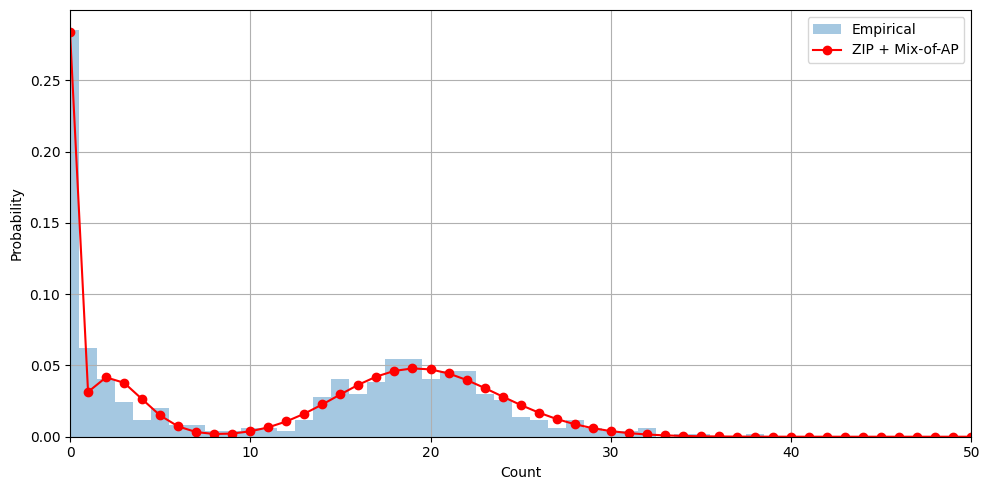

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.special import gammaln
from scipy.optimize import minimize

# 0) fish DataFrame should already be loaded
# Prepare multimodal_samples
fish_count     = fish["count"].values.astype(int)
poisson_sample = np.random.poisson(lam=20, size=len(fish_count))
multimodal_samples = np.concatenate([fish_count, poisson_sample])

# 1) Data split
y_all  = multimodal_samples.astype(int)
N      = len(y_all)
y_pos  = y_all[y_all > 0]
n_pos  = len(y_pos)
n_zero = N - n_pos

# 2) Zero-inflation pi
pi_hat = n_zero / N

# 3) Hyperparameters
K      = 3   # number of mixture components
degree = 2   # polynomial degree

# 4) Initialize parameters
# loglams: K values, logalphas: K*degree values, mix_logits: K values
init_loglams   = np.log(np.linspace(5.0, 20.0, K))
init_logalphas = np.log([1e-2] * (K * degree))
init_logits    = np.zeros(K)
init_params    = np.concatenate([init_loglams, init_logalphas, init_logits])

# 5) Negative log-likelihood
def neg_loglike_mixAP(params):
    loglams   = params[:K]
    lams      = np.exp(loglams)
    logalphas = params[K:K + K*degree]
    alphas    = np.exp(logalphas).reshape(K, degree)
    mix_logits= params[K + K*degree:]
    weights_raw = np.exp(mix_logits - np.max(mix_logits))
    weights     = weights_raw / weights_raw.sum()

    # compute Z_k for each component
    m_max = int(max(lams) + 5*np.sqrt(max(lams)))
    m     = np.arange(m_max+1)
    Zk    = np.array([
        np.sum(poisson.pmf(m, lams[k]) * 
               (1 + sum(alphas[k,j] * (m**(j+1)) for j in range(degree))))
        for k in range(K)
    ])

    # positive part log-likelihood
    ll_pos = 0.0
    for y in y_pos:
        comp = []
        for k in range(K):
            Tk_y = 1 + sum(alphas[k,j] * y**(j+1) for j in range(degree))
            logp = (-lams[k] + y*np.log(lams[k]) - gammaln(y+1)
                    + np.log(Tk_y) - np.log(Zk[k])
                    + np.log(weights[k]))
            comp.append(logp)
        ll_pos += np.logaddexp.reduce(comp)

    ll_zero = n_zero * np.log(pi_hat)
    ll_pos  = n_pos   * np.log(1 - pi_hat) + ll_pos
    return -(ll_zero + ll_pos)

# 6) Optimize
res = minimize(
    neg_loglike_mixAP,
    init_params,
    method="L-BFGS-B",
    options={"disp": True, "maxiter": 300}
)

# 7) Extract estimates
loglams    = res.x[:K];      lams    = np.exp(loglams)
logalphas  = res.x[K:K+K*degree]; alphas = np.exp(logalphas).reshape(K, degree)
mix_logits = res.x[K+K*degree:]
weights_raw= np.exp(mix_logits - np.max(mix_logits))
weights    = weights_raw / weights_raw.sum()

print(f"π (zero-inflation) = {pi_hat:.3f}")
for k in range(K):
    print(f"Component {k+1}: λ = {lams[k]:.3f}, α = {alphas[k].round(4)}, weight = {weights[k]:.3f}")

# 8) Compute and plot PMF
x   = np.arange(0, 51)
pmf = np.zeros_like(x, dtype=float)
pmf[0] = pi_hat
for k in range(K):
    # adjustment for x>0
    Tk = 1 + sum(alphas[k,j] * (x[1:]**(j+1)) for j in range(degree))
    # normalization Z_k
    m = np.arange(int(lams[k] + 5*np.sqrt(lams[k])) + 1)
    Tm = 1 + sum(alphas[k,j] * (m**(j+1)) for j in range(degree))
    Zk = np.sum(poisson.pmf(m, lams[k]) * Tm)
    pmf[1:] += (1 - pi_hat) * weights[k] * poisson.pmf(x[1:], lams[k]) * Tk / Zk

plt.figure(figsize=(10,5))
plt.hist(y_all, bins=np.arange(52)-0.5, density=True, alpha=0.4, label="Empirical")
plt.plot(x, pmf, 'o-', color='red', label="ZIP + Mix-of-AP")
plt.xlim(0,50); plt.xlabel("Count"); plt.ylabel("Probability")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

λ = 15.2267, π = 0.2838, α = [0.      0.      0.00019]


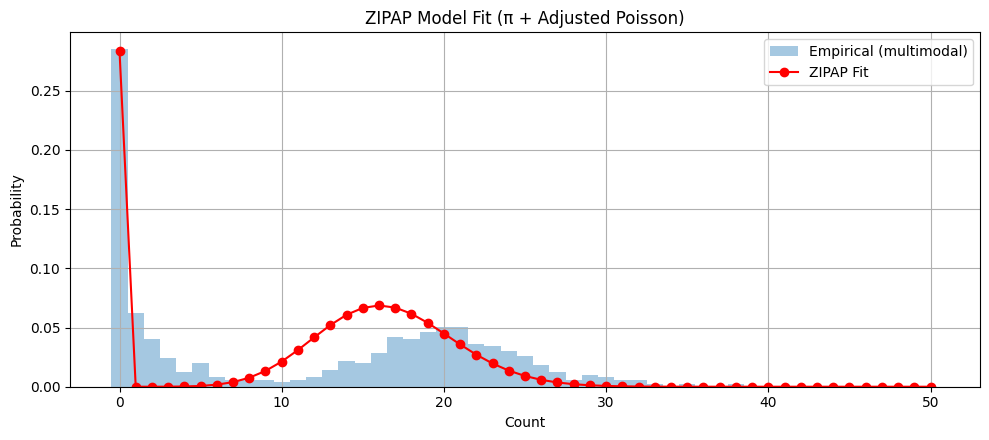

In [67]:
import numpy as np
from scipy.special import gammaln
from scipy.optimize import minimize
from scipy.stats import poisson

# 1. 데이터 준비
y_all  = multimodal_samples.astype(int)
n      = len(y_all)
y_pos  = y_all[y_all > 0]
n_pos  = len(y_pos)
n_zero = n - n_pos

# 2. 초기 추정치
pi_hat = n_zero / n
lambda_hat = np.mean(y_pos)
alpha_init = [0.01, 0.01, 0.01]  # α1, α2, α3
params_init = np.concatenate([[np.log(lambda_hat), np.log(pi_hat / (1 - pi_hat))], np.log(alpha_init)])

# 3. 정규화 상수 Z(λ, α)
def compute_Z(lam, alpha):
    return (1 + 
            (alpha[0] + alpha[1] + alpha[2]) * lam + 
            (alpha[1] + 3 * alpha[2]) * lam**2 + 
            alpha[2] * lam**3)

# 4. 로그우도 함수
def neg_loglike_zipap(params):
    log_lambda, logit_pi, *log_alphas = params
    lam = np.exp(log_lambda)
    pi = 1 / (1 + np.exp(-logit_pi))
    alpha = np.exp(log_alphas)
    Z = compute_Z(lam, alpha)

    ll = 0.0
    for y in y_all:
        T_y = 1 + alpha[0]*y + alpha[1]*y**2 + alpha[2]*y**3
        log_p = -lam + y*np.log(lam) - gammaln(y + 1) + np.log(T_y) - np.log(Z)
        if y == 0:
            p_zero = pi + (1 - pi) * np.exp(-lam) / Z
            ll += np.log(p_zero)
        else:
            ll += np.log(1 - pi) + log_p
    return -ll

# 5. 최적화
res = minimize(
    neg_loglike_zipap,
    params_init,
    method="L-BFGS-B",
    options={"disp": True, "maxiter": 500}
)

# 6. 결과 추출
log_lambda, logit_pi, *log_alphas = res.x
lam = np.exp(log_lambda)
pi = 1 / (1 + np.exp(-logit_pi))
alpha = np.exp(log_alphas)
print(f"λ = {lam:.4f}, π = {pi:.4f}, α = {np.round(alpha, 5)}")

import matplotlib.pyplot as plt
from scipy.stats import poisson

# 1. ZIPAP PMF 계산
x = np.arange(0, 51)
pmf_zipap = np.zeros_like(x, dtype=float)

Z = compute_Z(lam, alpha)

for i, y in enumerate(x):
    T_y = 1 + alpha[0]*y + alpha[1]*y**2 + alpha[2]*y**3
    if y == 0:
        pmf_zipap[i] = pi + (1 - pi) * poisson.pmf(0, lam) * T_y / Z
    else:
        pmf_zipap[i] = (1 - pi) * poisson.pmf(y, lam) * T_y / Z

# 2. 히스토그램 + 모델 PMF 그리기
plt.figure(figsize=(10, 4.5))
plt.hist(y_all, bins=np.arange(52)-0.5, density=True, alpha=0.4, label="Empirical (multimodal)")
plt.plot(x, pmf_zipap, 'o-', color='red', label="ZIPAP Fit")
plt.xlabel("Count")
plt.ylabel("Probability")
plt.title("ZIPAP Model Fit (π + Adjusted Poisson)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



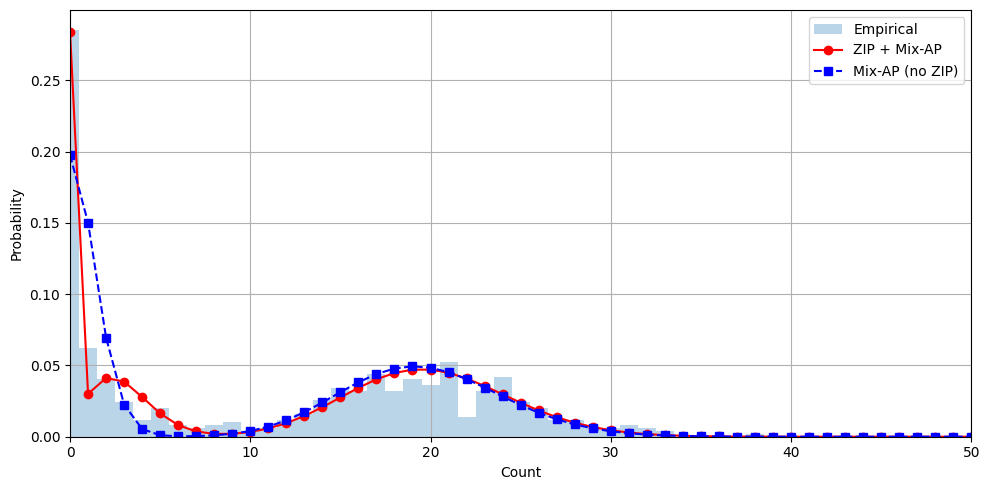

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.special import gammaln
from scipy.optimize import minimize

# 0) fish DataFrame should already be loaded
fish_count     = fish["count"].values.astype(int)
poisson_sample = np.random.poisson(lam=20, size=len(fish_count))
y_all          = np.concatenate([fish_count, poisson_sample]).astype(int)

# common settings
K      = 3    # mixture components
degree = 2    # polynomial degree

# initialize
init_loglams   = np.log(np.linspace(5.0, 20.0, K))
init_logalphas = np.log([1e-2] * (K * degree))
init_logits    = np.zeros(K)
init_params    = np.concatenate([init_loglams, init_logalphas, init_logits])

# 1) ZIP + Mix-of-AP ================================================
N      = len(y_all)
n_pos  = np.sum(y_all > 0)
n_zero = N - n_pos
pi_hat = n_zero / N

def neg_loglike_zip_mixAP(params):
    loglams    = params[:K]
    lams       = np.exp(loglams)
    logalphas  = params[K:K + K*degree]
    alphas     = np.exp(logalphas).reshape(K, degree)
    mix_logits = params[K + K*degree:]
    weights_raw= np.exp(mix_logits - np.max(mix_logits))
    weights    = weights_raw / weights_raw.sum()

    # compute Z_k
    m_max = int(np.max(lams) + 5*np.sqrt(np.max(lams)))
    m     = np.arange(m_max+1)
    Zk    = np.array([
        np.sum(poisson.pmf(m, lams[k]) *
               (1 + sum(alphas[k,j] * m**(j+1) for j in range(degree))))
        for k in range(K)
    ])

    # zero part
    ll_zero = n_zero * np.log(pi_hat)

    # positive part
    ll_pos = n_pos * np.log(1 - pi_hat)
    for y in y_all[y_all>0]:
        comp = []
        for k in range(K):
            Tk_y = 1 + sum(alphas[k,j] * y**(j+1) for j in range(degree))
            comp.append(
                -lams[k] + y*np.log(lams[k]) - gammaln(y+1)
                + np.log(Tk_y) - np.log(Zk[k])
                + np.log(weights[k])
            )
        ll_pos += np.logaddexp.reduce(comp)

    return -(ll_zero + ll_pos)

res_zip = minimize(
    neg_loglike_zip_mixAP,
    init_params,
    method="L-BFGS-B",
    options={"disp": True, "maxiter": 300}
)

# extract ZIP+Mix-AP params
loglams_zip   = res_zip.x[:K];      lams_zip   = np.exp(loglams_zip)
logalphas_zip = res_zip.x[K:K+K*degree]; alphas_zip = np.exp(logalphas_zip).reshape(K, degree)
mix_logits_zip= res_zip.x[K+K*degree:]
weights_zip   = np.exp(mix_logits_zip - np.max(mix_logits_zip))
weights_zip   = weights_zip / weights_zip.sum()

# compute PMF for ZIP+Mix-AP
x   = np.arange(0,51)
pmf_zip = np.zeros_like(x, float)
pmf_zip[0] = pi_hat
for k in range(K):
    Tk    = 1 + sum(alphas_zip[k,j]*x[1:]**(j+1) for j in range(degree))
    m     = np.arange(int(lams_zip[k] + 5*np.sqrt(lams_zip[k]))+1)
    Tm    = 1 + sum(alphas_zip[k,j]*m**(j+1) for j in range(degree))
    Zk    = np.sum(poisson.pmf(m, lams_zip[k]) * Tm)
    pmf_zip[1:] += (1-pi_hat)*weights_zip[k]*poisson.pmf(x[1:], lams_zip[k])*Tk/Zk

# 2)    Mix-of-AP only (no ZIP) ===================================
def neg_loglike_mixAP(params):
    loglams    = params[:K]
    lams       = np.exp(loglams)
    logalphas  = params[K:K + K*degree]
    alphas     = np.exp(logalphas).reshape(K, degree)
    mix_logits = params[K + K*degree:]
    weights_raw= np.exp(mix_logits - np.max(mix_logits))
    weights    = weights_raw / weights_raw.sum()

    # compute Z_k
    m_max = int(np.max(lams) + 5*np.sqrt(np.max(lams)))
    m     = np.arange(m_max+1)
    Zk    = np.array([
        np.sum(poisson.pmf(m, lams[k]) *
               (1 + sum(alphas[k,j] * m**(j+1) for j in range(degree))))
        for k in range(K)
    ])

    # mixture log-likelihood
    ll = 0.0
    for y in y_all:
        comp = []
        for k in range(K):
            Tk_y = 1 + sum(alphas[k,j] * y**(j+1) for j in range(degree))
            comp.append(
                -lams[k] + y*np.log(lams[k]) - gammaln(y+1)
                + np.log(Tk_y) - np.log(Zk[k])
                + np.log(weights[k])
            )
        ll += np.logaddexp.reduce(comp)
    return -ll

res_nozip = minimize(
    neg_loglike_mixAP,
    init_params,
    method="L-BFGS-B",
    options={"disp": True, "maxiter": 300}
)

# extract Mix-AP only params
loglams_nz   = res_nozip.x[:K];      lams_nz   = np.exp(loglams_nz)
logalphas_nz = res_nozip.x[K:K+K*degree]; alphas_nz = np.exp(logalphas_nz).reshape(K, degree)
mix_logits_nz= res_nozip.x[K+K*degree:]
weights_nz   = np.exp(mix_logits_nz - np.max(mix_logits_nz))
weights_nz   = weights_nz / weights_nz.sum()

# compute PMF for Mix-AP only
pmf_nz = np.zeros_like(x, float)
for k in range(K):
    Tk    = 1 + sum(alphas_nz[k,j]*x**(j+1) for j in range(degree))
    m     = np.arange(int(lams_nz[k] + 5*np.sqrt(lams_nz[k]))+1)
    Tm    = 1 + sum(alphas_nz[k,j]*m**(j+1) for j in range(degree))
    Zk    = np.sum(poisson.pmf(m, lams_nz[k]) * Tm)
    pmf_nz += weights_nz[k] * poisson.pmf(x, lams_nz[k]) * Tk/Zk

# 3) Plot 비교 =====================================================
plt.figure(figsize=(10,5))
plt.hist(y_all, bins=np.arange(52)-0.5, density=True, alpha=0.3, label="Empirical")
plt.plot(x, pmf_zip, 'o-', color='red',   label="ZIP + Mix-AP")
plt.plot(x, pmf_nz,  's--',color='blue',  label="Mix-AP (no ZIP)")
plt.xlim(0,50)
plt.xlabel("Count"); plt.ylabel("Probability")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


weights: [0.285 0.705 0.01 ]
pis:     [0.318 0.241 0.602]
lams:    [  2.198  19.343 106.025]
alphas:  [[0.    0.033]
 [0.    0.001]
 [0.029 0.   ]]


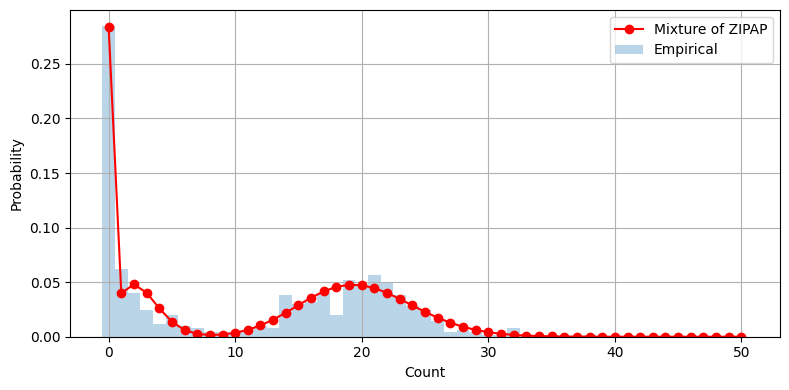

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.special import gammaln
from scipy.optimize import minimize

class MixtureZIPAP:
    """
    Mixture of Zero-Inflated Adjusted Poisson (ZIPAP) components.

    f(y) = \sum_{k=1}^K w_k * f_k(y),
    where for each component k:
      P_k(0) = π_k + (1-π_k) * e^{-λ_k}/Z_k,
      P_k(y>0) = (1-π_k) * Poisson(y;λ_k) * T_k(y)/Z_k,
      T_k(y) = 1 + \sum_{j=1}^d α_{k,j} y^{j},
      Z_k = \sum_{m=0}^∞ Poisson(m;λ_k) T_k(m).
    """
    def __init__(self, y, K=3, degree=2):
        self.y = np.asarray(y, int)
        self.K = K
        self.d = degree

    def _unpack(self, params):
        # params layout: [log_w (K), logit_pi (K), log_lambda (K), log_alpha (K*d)]
        idx = 0
        log_w     = params[idx:idx+self.K]; idx += self.K
        logit_pi  = params[idx:idx+self.K]; idx += self.K
        log_lambda= params[idx:idx+self.K]; idx += self.K
        log_alpha = params[idx:].reshape(self.K, self.d)
        # mixture weights
        w_raw  = np.exp(log_w - np.max(log_w))
        w      = w_raw / w_raw.sum()
        # zero-inflation probs
        pi     = 1/(1+np.exp(-logit_pi))
        # lambdas
        lam    = np.exp(log_lambda)
        # alphas
        alphas = np.exp(log_alpha)
        return w, pi, lam, alphas

    def _Zk(self, lam, alpha):
        # closed-form normalization up to degree d
        # here assume d<=3
        # Z = sum_m Poisson(m;lam)*[1+sum_j α_j m^j]
        m_max = int(lam + 5*np.sqrt(lam))
        m     = np.arange(m_max+1)
        Tm    = 1 + sum(alpha[j]*m**(j+1) for j in range(self.d))
        Z     = np.sum(poisson.pmf(m, lam) * Tm)
        return Z

    def loglike(self, params):
        w, pi, lam, alphas = self._unpack(params)
        ll = 0.0
        # precompute Zk
        Zk = np.array([self._Zk(lam[k], alphas[k]) for k in range(self.K)])
        for y in self.y:
            # component log-probs
            comp = np.zeros(self.K)
            for k in range(self.K):
                if y == 0:
                    p0 = pi[k] + (1-pi[k]) * np.exp(-lam[k]) / Zk[k]
                    comp[k] = np.log(p0)
                else:
                    Tk = 1 + sum(alphas[k,j]*y**(j+1) for j in range(self.d))
                    logp = (-lam[k] + y*np.log(lam[k]) - gammaln(y+1)
                            + np.log(Tk) - np.log(Zk[k])
                            + np.log(1-pi[k]))
                    comp[k] = logp
                # add mixture weight
                comp[k] += np.log(w[k])
            ll += np.logaddexp.reduce(comp)
        return -ll

    def fit(self, init_params=None, method='L-BFGS-B', options=None):
        if init_params is None:
            # simple init: equal weights, pi=0.2, lam spread, alpha small
            log_w     = np.zeros(self.K)
            logit_pi  = np.log(0.2/(1-0.2)) * np.ones(self.K)
            log_lambda= np.log(np.linspace(5,20,self.K))
            log_alpha = np.log(1e-2) * np.ones(self.K*self.d)
            init_params = np.concatenate([log_w, logit_pi, log_lambda, log_alpha])
        if options is None:
            options = {'disp': True, 'maxiter':300}
        res = minimize(self.loglike, init_params, method=method, options=options)
        self.res = res
        self.w, self.pi, self.lam, self.alphas = self._unpack(res.x)
        return res

    def pmf(self, x):
        # compute mixture pmf for array x
        w, pi, lam, alphas = self.w, self.pi, self.lam, self.alphas
        Zk = np.array([self._Zk(lam[k], alphas[k]) for k in range(self.K)])
        pmf = np.zeros_like(x, dtype=float)
        for k in range(self.K):
            # per-component pmf
            pk = np.zeros_like(x, float)
            # zero
            pk[0] = pi[k] + (1-pi[k]) * np.exp(-lam[k]) / Zk[k]
            # positive
            for i,y in enumerate(x[1:], start=1):
                Tk = 1 + sum(alphas[k,j]*y**(j+1) for j in range(self.d))
                pk[i] = (1-pi[k]) * poisson.pmf(y, lam[k]) * Tk / Zk[k]
            pmf += w[k]*pk
        return pmf

# === Example Usage ===
if __name__ == '__main__':
    import pandas as pd
    # 0) fish DataFrame should already be loaded
    # prepare multimodal samples
    fish_count     = fish['count'].values.astype(int)
    poisson_sample = np.random.poisson(lam=20, size=len(fish_count))
    y_all          = np.concatenate([fish_count, poisson_sample]).astype(int)

    # fit mixture of ZIPAP
    model = MixtureZIPAP(y_all, K=3, degree=2)
    res = model.fit()
    print('weights:', np.round(model.w,3))
    print('pis:    ', np.round(model.pi,3))
    print('lams:   ', np.round(model.lam,3))
    print('alphas: ', np.round(model.alphas,3))

    # plot empirical vs mixture ZIPAP
    x, bins = np.arange(0,51), None
    empirical, _ = np.histogram(y_all, bins=np.arange(52)-0.5, density=True)
    pmf_mix     = model.pmf(x)
    plt.figure(figsize=(8,4))
    plt.bar(x, empirical, width=1, alpha=0.3, label='Empirical')
    plt.plot(x, pmf_mix, 'r-o', label='Mixture of ZIPAP')
    plt.xlabel('Count'); plt.ylabel('Probability')
    plt.legend(); plt.grid(); plt.tight_layout()
    plt.show()


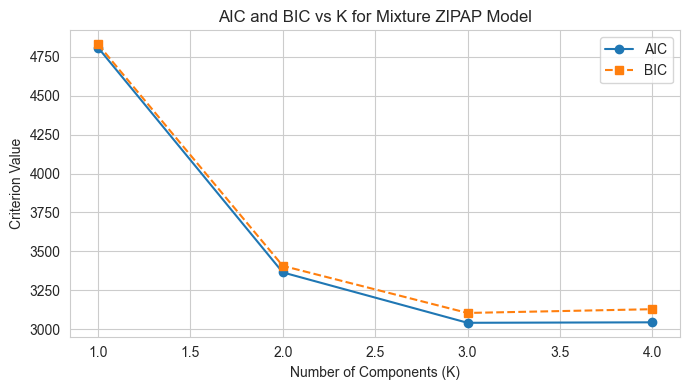

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.special import gammaln
from scipy.optimize import minimize, Bounds

# Ensure fish DataFrame is loaded (with 'count' column)
# Example: fish = pd.read_csv("path_to_fish.csv")

# Define the Mixture of ZIPAP model with bounds
class MixtureZIPAP:
    def __init__(self, y, K=3, degree=2):
        self.y = np.asarray(y, int)
        self.K = K
        self.d = degree

    def _unpack(self, params):
        idx = 0
        log_w     = params[idx:idx + self.K]; idx += self.K
        logit_pi  = params[idx:idx + self.K]; idx += self.K
        log_lambda= params[idx:idx + self.K]; idx += self.K
        log_alpha = params[idx:].reshape(self.K, self.d)

        w_raw  = np.exp(log_w - np.max(log_w))
        w      = w_raw / w_raw.sum()
        pi     = 1 / (1 + np.exp(-logit_pi))
        lam    = np.exp(log_lambda)
        alphas = np.exp(log_alpha)
        return w, pi, lam, alphas

    def _Zk(self, lam, alpha):
        m_max = int(min(lam + 5 * np.sqrt(lam), 1000))
        m     = np.arange(m_max + 1)
        Tm    = 1 + sum(alpha[j] * m ** (j + 1) for j in range(self.d))
        return np.sum(poisson.pmf(m, lam) * Tm)

    def loglike(self, params):
        w, pi, lam, alphas = self._unpack(params)
        ll = 0.0
        Zk = np.array([self._Zk(lam[k], alphas[k]) for k in range(self.K)])
        for y in self.y:
            comp = np.zeros(self.K)
            for k in range(self.K):
                if y == 0:
                    p0 = pi[k] + (1 - pi[k]) * np.exp(-lam[k]) / Zk[k]
                    comp[k] = np.log(p0)
                else:
                    Tk = 1 + sum(alphas[k, j] * y ** (j + 1) for j in range(self.d))
                    logp = (-lam[k] + y * np.log(lam[k]) - gammaln(y + 1)
                            + np.log(Tk) - np.log(Zk[k])
                            + np.log(1 - pi[k]))
                    comp[k] = logp
                comp[k] += np.log(w[k])
            ll += np.logaddexp.reduce(comp)
        return -ll

    def fit(self, init_params=None, method='L-BFGS-B', options=None):
        # initialize parameters if not provided
        if init_params is None:
            log_w      = np.zeros(self.K)
            logit_pi   = np.log(0.2/(1-0.2)) * np.ones(self.K)
            log_lambda = np.log(np.linspace(5, 20, self.K))
            log_alpha  = np.log(1e-2) * np.ones(self.K * self.d)
            init_params = np.concatenate([log_w, logit_pi, log_lambda, log_alpha])
        if options is None:
            options = {'disp': False, 'maxiter': 300}

        # set bounds
        bounds = []
        # log_w: allow [-5,5]
        bounds += [(-5,5)] * self.K
        # logit_pi: avoid extremes
        bounds += [(-5,5)] * self.K
        # log_lambda: λ ∈ [1e-2, 200]
        bounds += [(np.log(1e-2), np.log(200))] * self.K
        # log_alpha: α ∈ [1e-6, 10]
        bounds += [(np.log(1e-6), np.log(10))] * (self.K * self.d)
        bounds = Bounds(*zip(*bounds))

        res = minimize(self.loglike, init_params, method=method,
                       bounds=bounds, options=options)
        self.res = res
        self.w, self.pi, self.lam, self.alphas = self._unpack(res.x)
        self.n_params = len(res.x)
        self.loglike_val = -res.fun
        return res

    def pmf(self, x):
        w, pi, lam, alphas = self.w, self.pi, self.lam, self.alphas
        Zk = np.array([self._Zk(lam[k], alphas[k]) for k in range(self.K)])
        pmf = np.zeros_like(x, dtype=float)
        for k in range(self.K):
            pk = np.zeros_like(x, float)
            pk[0] = pi[k] + (1 - pi[k]) * np.exp(-lam[k]) / Zk[k]
            for i, y in enumerate(x[1:], start=1):
                Tk = 1 + sum(alphas[k, j] * y ** (j + 1) for j in range(self.d))
                pk[i] = (1 - pi[k]) * poisson.pmf(y, lam[k]) * Tk / Zk[k]
            pmf += w[k] * pk
        return pmf

# Prepare multimodal data
fish_count = fish["count"].values.astype(int)
poisson_sample = np.random.poisson(lam=20, size=len(fish_count))
y_all = np.concatenate([fish_count, poisson_sample])

# Evaluate models for K=1..4 using AIC/BIC
results = []
for K in range(1, 5):
    model = MixtureZIPAP(y_all, K=K, degree=2)
    res = model.fit()
    ll = model.loglike_val
    p = model.n_params
    n = len(y_all)
    AIC = 2*p - 2*ll
    BIC = p*np.log(n) - 2*ll
    results.append({"K": K, "AIC": AIC, "BIC": BIC})

df = pd.DataFrame(results)

# Display criteria and plot
import seaborn as sns
sns.set_style("whitegrid")

# Plot
plt.figure(figsize=(7,4))
plt.plot(df["K"], df["AIC"], 'o-', label="AIC")
plt.plot(df["K"], df["BIC"], 's--', label="BIC")
plt.xlabel("Number of Components (K)")
plt.ylabel("Criterion Value")
plt.title("AIC and BIC vs K for Mixture ZIPAP Model")
plt.legend()
plt.tight_layout()
plt.show()

,K,AIC,BIC
0,1,2251.854473,2269.461777
1,2,1235.294331,1270.508941
2,3,1013.975069,1066.796982
3,4,987.626042,1058.055260



K=1
  AIC=2251.9, BIC=2269.5
  weights = [1.]
  pis     = [0.568]
  lams    = [7.444]
  alphas  =
[[0.     0.0017]]

K=2
  AIC=1235.3, BIC=1270.5
  weights = [0.93 0.07]
  pis     = [0.57  0.355]
  lams    = [ 3.221 41.753]
  alphas  =
[[0.     0.0134]
 [0.     0.0001]]

K=3
  AIC=1014.0, BIC=1066.8
  weights = [0.888 0.095 0.017]
  pis     = [0.56  0.357 0.517]
  lams    = [  2.439  21.919 106.519]
  alphas  =
[[0.     0.0253]
 [0.     0.0007]
 [0.     0.    ]]

K=4
  AIC=987.6, BIC=1058.1
  weights = [0.782 0.128 0.069 0.02 ]
  pis     = [0.529 0.407 0.461 0.605]
  lams    = [  1.661   9.     27.174 105.116]
  alphas  =
[[0.0058 0.045 ]
 [0.0018 0.    ]
 [0.0109 0.0009]
 [0.0115 0.0059]]


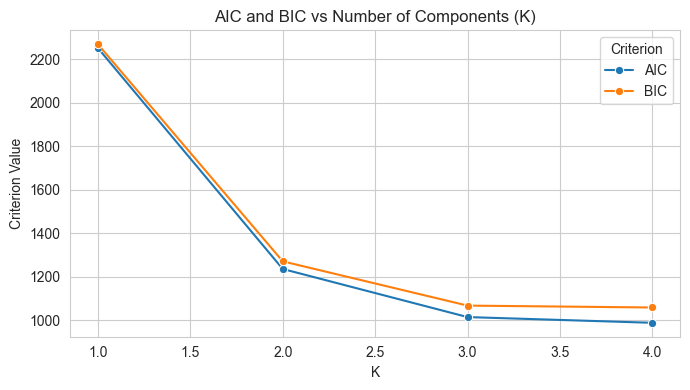

In [119]:
# Mixture ZIPAP class with bounds
class MixtureZIPAP:
    def __init__(self, y, K=3, degree=2):
        self.y = np.asarray(y, int)
        self.K = K
        self.d = degree

    def _unpack(self, params):
        idx = 0
        log_w     = params[idx:idx + self.K]; idx += self.K
        logit_pi  = params[idx:idx + self.K]; idx += self.K
        log_lambda= params[idx:idx + self.K]; idx += self.K
        log_alpha = params[idx:].reshape(self.K, self.d)

        w_raw  = np.exp(log_w - np.max(log_w))
        w      = w_raw / w_raw.sum()
        pi     = 1 / (1 + np.exp(-logit_pi))
        lam    = np.exp(log_lambda)
        alphas = np.exp(log_alpha)
        return w, pi, lam, alphas

    def _Zk(self, lam, alpha):
        m_max = int(min(lam + 5 * np.sqrt(lam), 1000))
        m     = np.arange(m_max + 1)
        Tm    = 1 + sum(alpha[j] * m ** (j + 1) for j in range(self.d))
        return np.sum(poisson.pmf(m, lam) * Tm)

    def loglike(self, params):
        w, pi, lam, alphas = self._unpack(params)
        ll = 0.0
        Zk = np.array([self._Zk(lam[k], alphas[k]) for k in range(self.K)])
        for y in self.y:
            comp = np.zeros(self.K)
            for k in range(self.K):
                if y == 0:
                    p0 = pi[k] + (1 - pi[k]) * np.exp(-lam[k]) / Zk[k]
                    comp[k] = np.log(p0)
                else:
                    Tk = 1 + sum(alphas[k, j] * y ** (j + 1) for j in range(self.d))
                    logp = (-lam[k] + y * np.log(lam[k]) - gammaln(y + 1)
                            + np.log(Tk) - np.log(Zk[k])
                            + np.log(1 - pi[k]))
                    comp[k] = logp
                comp[k] += np.log(w[k])
            ll += np.logaddexp.reduce(comp)
        return -ll

    def fit(self, init_params=None, method='L-BFGS-B', options=None):
        if init_params is None:
            log_w      = np.zeros(self.K)
            logit_pi   = np.log(0.2/(1-0.2)) * np.ones(self.K)
            log_lambda = np.log(np.linspace(5, 20, self.K))
            log_alpha  = np.log(1e-2) * np.ones(self.K * self.d)
            init_params = np.concatenate([log_w, logit_pi, log_lambda, log_alpha])
        if options is None:
            options = {'disp': False, 'maxiter': 300}

        # bounds
        bounds = []
        bounds += [(-5,5)] * self.K  # log_w
        bounds += [(-5,5)] * self.K  # logit_pi
        bounds += [(np.log(1e-2), np.log(200))] * self.K  # log_lambda
        bounds += [(np.log(1e-6), np.log(10))] * (self.K * self.d)  # log_alpha
        bounds = Bounds(*zip(*bounds))

        res = minimize(self.loglike, init_params, method=method,
                       bounds=bounds, options=options)
        self.res = res
        self.w, self.pi, self.lam, self.alphas = self._unpack(res.x)
        self.n_params = len(res.x)
        self.loglike_val = -res.fun
        return res

    def pmf(self, x):
        w, pi, lam, alphas = self.w, self.pi, self.lam, self.alphas
        Zk = np.array([self._Zk(lam[k], alphas[k]) for k in range(self.K)])
        pmf = np.zeros_like(x, dtype=float)
        for k in range(self.K):
            pk = np.zeros_like(x, float)
            pk[0] = pi[k] + (1 - pi[k]) * np.exp(-lam[k]) / Zk[k]
            for i, y in enumerate(x[1:], start=1):
                Tk = 1 + sum(alphas[k, j] * y ** (j + 1) for j in range(self.d))
                pk[i] = (1 - pi[k]) * poisson.pmf(y, lam[k]) * Tk / Zk[k]
            pmf += w[k] * pk
        return pmf

# Evaluate and print fitted results for K=1..4
results = []
for K in range(1, 5):
    model = MixtureZIPAP(y_all, K=K, degree=2)
    res = model.fit()
    ll = model.loglike_val
    p = model.n_params
    n = len(y_all)
    AIC = 2*p - 2*ll
    BIC = p*np.log(n) - 2*ll
    results.append({"K": K, "AIC": AIC, "BIC": BIC,
                    "weights": model.w, 
                    "pis": model.pi,
                    "lams": model.lam,
                    "alphas": model.alphas})

# Display selection table
df = pd.DataFrame(results, columns=["K","AIC","BIC"])
display(df)

# Print parameter estimates
for r in results:
    print(f"\nK={r['K']}")
    print(f"  AIC={r['AIC']:.1f}, BIC={r['BIC']:.1f}")
    print(f"  weights = {np.round(r['weights'],3)}")
    print(f"  pis     = {np.round(r['pis'],3)}")
    print(f"  lams    = {np.round(r['lams'],3)}")
    print(f"  alphas  =\n{np.round(r['alphas'],4)}")

# Plot AIC/BIC
df_plot = df.melt(id_vars="K", value_vars=["AIC","BIC"], var_name="Criterion", value_name="Value")
plt.figure(figsize=(7,4))
sns.lineplot(data=df_plot, x="K", y="Value", hue="Criterion", marker="o")
plt.title("AIC and BIC vs Number of Components (K)")
plt.xlabel("K")
plt.ylabel("Criterion Value")
plt.grid(True)
plt.tight_layout()
plt.show()

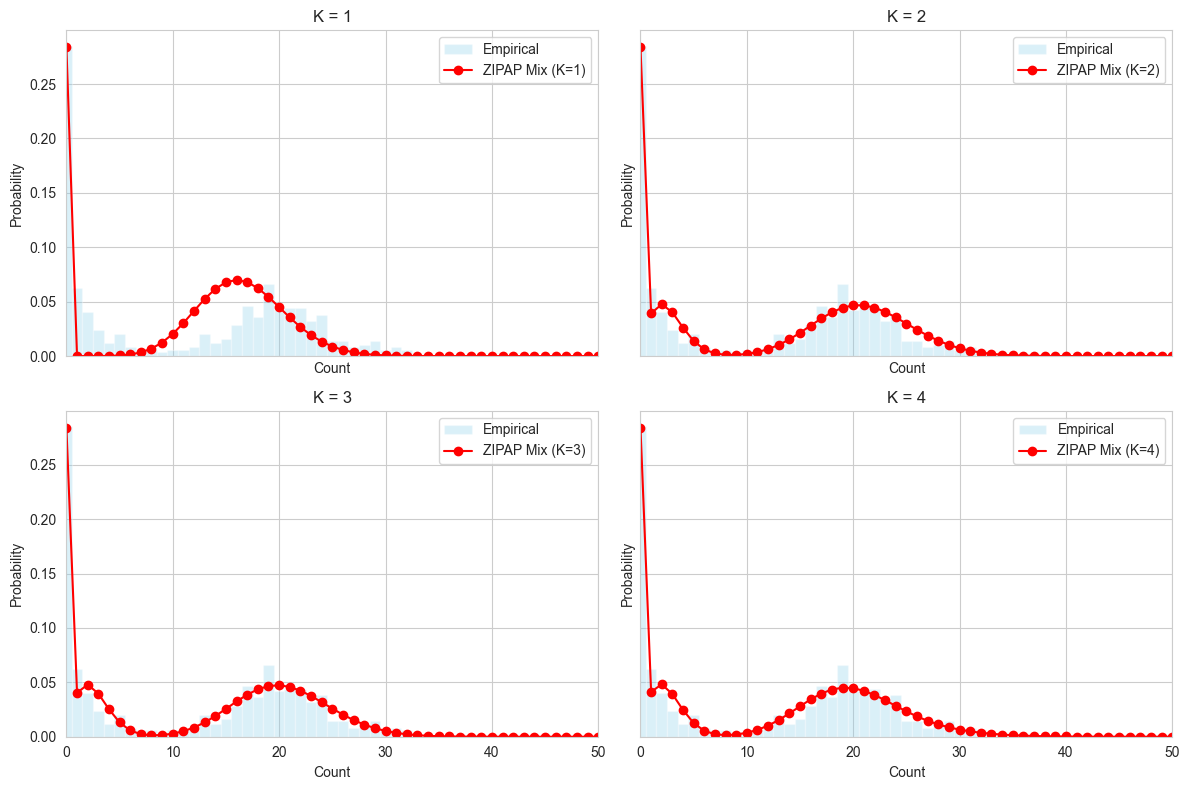

In [76]:
# x-range for PMF plotting
x = np.arange(0, 51)

# === Plotting one panel per K ===
Ks = [1, 2, 3, 4]
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

for ax, K in zip(axes.flatten(), Ks):
    # Fit model
    model = MixtureZIPAP(y_all, K=K, degree=2)
    model.fit()
    pmf = model.pmf(x)
    
    # Empirical histogram
    ax.hist(y_all, bins=np.arange(x.max()+2)-0.5, density=True,
            alpha=0.3, color="skyblue", label="Empirical")
    
    # Model PMF
    ax.plot(x, pmf, 'o-', color='red', label=f'ZIPAP Mix (K={K})')
    
    ax.set_title(f"K = {K}")
    ax.set_xlim(0, 50)
    ax.set_xlabel("Count")
    ax.set_ylabel("Probability")
    ax.legend()

plt.tight_layout()
plt.show()

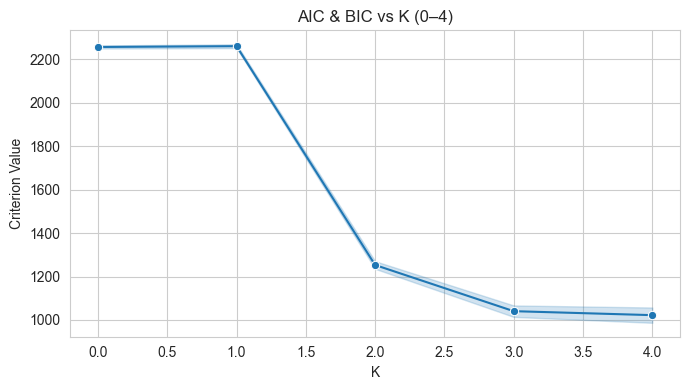

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.special import gammaln
from scipy.optimize import minimize
from scipy.optimize import Bounds
import seaborn as sns

# --- 0) Ensure y_all is defined ---
y_all = fish["count"].astype(int).values

# --- 1) Pure ZIPAP for K=0 ---
class ZIPAP:
    def __init__(self, y, degree=2):
        self.y = np.asarray(y, int)
        self.degree = degree

    def neg_ll(self, params):
        logit_pi, loglam, *eta = params
        pi    = 1/(1+np.exp(-logit_pi))
        lam   = np.exp(loglam)
        alpha = np.exp(eta)
        # closed-form Z
        Z0 = 1 + alpha[0]*lam + alpha[1]*(lam**2 + lam)
        ll = 0.0
        for yi in self.y:
            if yi == 0:
                ll += np.log(pi + (1-pi)*np.exp(-lam)/Z0)
            else:
                logp = -lam + yi*np.log(lam) - gammaln(yi+1)
                Ty   = 1 + alpha[0]*yi + alpha[1]*yi**2
                ll  += np.log(1-pi) + logp + np.log(Ty) - np.log(Z0)
        return -ll

    def fit(self):
        pi0   = np.mean(self.y==0)
        init  = np.concatenate([[np.log(pi0/(1-pi0)), np.log(np.mean(self.y[self.y>0]))],
                                np.log([1e-2,1e-2])])
        bnds  = [(-5,5),(np.log(1e-2), np.log(200))] + [(-10,10)]*2
        res   = minimize(self.neg_ll, init, method="L-BFGS-B", bounds=bnds)
        x     = res.x
        self.pi     = 1/(1+np.exp(-x[0]))
        self.lam    = np.exp(x[1])
        self.alpha  = np.exp(x[2:])
        self.loglik = -res.fun
        self.np     = len(x)
        return self

    def pmf(self, x):
        pi, lam, a = self.pi, self.lam, self.alpha
        Z0    = 1 + a[0]*lam + a[1]*(lam**2+lam)
        pmf   = np.zeros_like(x, float)
        pmf[0] = pi + (1-pi)*np.exp(-lam)/Z0
        for i, xi in enumerate(x[1:],1):
            logp   = -lam + xi*np.log(lam) - gammaln(xi+1)
            Ty     = 1 + a[0]*xi + a[1]*xi**2
            pmf[i] = (1-pi)*np.exp(logp)*Ty/Z0
        return pmf

# --- 2) Mixture ZIPAP for K>=1 ---
class MixtureZIPAP:
    def __init__(self, y, K=3, degree=2):
        self.y = np.asarray(y, int)
        self.K = K
        self.d = degree

    def _unpack(self, params):
        idx = 0
        log_w      = params[idx:idx+self.K]; idx+=self.K
        logit_pi   = params[idx:idx+self.K]; idx+=self.K
        log_lambda = params[idx:idx+self.K]; idx+=self.K
        log_alpha  = params[idx:].reshape(self.K, self.d)
        w_raw      = np.exp(log_w - np.max(log_w))
        w          = w_raw / w_raw.sum()
        pi         = 1/(1+np.exp(-logit_pi))
        lam        = np.exp(log_lambda)
        alphas     = np.exp(log_alpha)
        return w, pi, lam, alphas

    def _Zk(self, lam, alpha):
        m_max = int(min(lam + 5*np.sqrt(lam), 1000))
        m     = np.arange(m_max+1)
        Tm    = 1 + sum(alpha[j] * m**(j+1) for j in range(self.d))
        return np.sum(poisson.pmf(m, lam) * Tm)

    def loglike(self, params):
        w, pi, lam, alphas = self._unpack(params)
        Zk = np.array([self._Zk(lam[k], alphas[k]) for k in range(self.K)])
        ll = 0.0
        for yi in self.y:
            comp = []
            for k in range(self.K):
                if yi == 0:
                    p0 = pi[k] + (1-pi[k])*np.exp(-lam[k])/Zk[k]
                    comp.append(np.log(p0))
                else:
                    Tk = 1 + sum(alphas[k,j]*yi**(j+1) for j in range(self.d))
                    logp = -lam[k] + yi*np.log(lam[k]) - gammaln(yi+1)
                    comp.append(np.log(1-pi[k]) + logp + np.log(Tk) - np.log(Zk[k]))
                comp[-1] += np.log(w[k])
            ll += np.logaddexp.reduce(comp)
        return -ll

    def fit(self, init_params=None, method='L-BFGS-B', options=None):
        if init_params is None:
            log_w      = np.zeros(self.K)
            logit_pi   = np.log(0.2/0.8)*np.ones(self.K)
            log_lambda = np.log(np.linspace(5,20,self.K))
            log_alpha  = np.log(1e-2)*np.ones(self.K*self.d)
            init_params= np.concatenate([log_w,logit_pi,log_lambda,log_alpha])
        if options is None:
            options = {'disp': False, 'maxiter': 300}

        bnds = [(-5,5)]*self.K + [(-5,5)]*self.K + \
               [(np.log(1e-2),np.log(200))]*self.K + \
               [(np.log(1e-6),np.log(10))]*(self.K*self.d)
        bnds = Bounds(*zip(*bnds))

        res = minimize(self.loglike, init_params, method=method,
                       bounds=bnds, options=options)
        self.res         = res
        self.w, self.pi, self.lam, self.alphas = self._unpack(res.x)
        self.n_params    = len(res.x)
        self.loglik_val  = -res.fun
        return self

    def pmf(self, x):
        w, pi, lam, alphas = self.w, self.pi, self.lam, self.alphas
        Zk = np.array([self._Zk(lam[k], alphas[k]) for k in range(self.K)])
        pmf = np.zeros_like(x, float)
        for k in range(self.K):
            pk = np.zeros_like(x, float)
            pk[0] = pi[k] + (1-pi[k])*np.exp(-lam[k])/Zk[k]
            for i, xi in enumerate(x[1:],1):
                Tk = 1 + sum(alphas[k,j]*xi**(j+1) for j in range(self.d))
                pk[i] = (1-pi[k])*poisson.pmf(xi,lam[k])*Tk/Zk[k]
            pmf += w[k]*pk
        return pmf

# --- 3) Fit for K=0..4 and summarize ---
x       = np.arange(0,51)
results = []

for K in range(0,5):
    if K == 0:
        m   = ZIPAP(y_all, degree=2).fit()
        w   = [1.0]
        pis = [m.pi]
        lams= [m.lam]
        als = [m.alpha]
        ll  = m.loglik
        p   = m.np
    else:
        m   = MixtureZIPAP(y_all, K=K, degree=2).fit()
        w   = m.w
        pis = m.pi
        lams= m.lam
        als = m.alphas
        ll  = m.loglik_val
        p   = m.n_params

    n = len(y_all)
    AIC = 2*p - 2*ll
    BIC = p*np.log(n) - 2*ll

    results.append({
        "K":K, "AIC":AIC, "BIC":BIC,
        "weights":w, "pis":pis,
        "lams":lams, "alphas":als
    })

df = pd.DataFrame(results)

# --- 4) Plot AIC/BIC ---
df_plot = df.melt(id_vars="K", value_vars=["AIC","BIC"],
                   var_name="Criterion", value_name="Value")
plt.figure(figsize=(7,4))
sns.lineplot(data=df_plot, x="K", y="Value", marker="o")
plt.title("AIC & BIC vs K (0–4)")
plt.xlabel("K"); plt.ylabel("Criterion Value")
plt.grid(True); plt.tight_layout()
plt.show()





In [122]:
import numpy as np
import pandas as pd

# 1) y_all 재정의 (fish DataFrame이 메모리에 올라와 있어야 합니다)
y_all = fish["count"].astype(int).values

# 2) x축 (0~50)
x = np.arange(0, 51)

# 3) 실제(empirical) 분포 계산
emp_counts = np.bincount(y_all, minlength=x.max()+1)[x]
emp_prob   = emp_counts / len(y_all)

# 4) 테이블 초기화
df = pd.DataFrame({
    "Count":      x,
    "Empirical":  emp_prob
})

# 5) K=0(ZIPAP)부터 K=4까지 반복하며 피팅된 PMF 추가
for K in range(0, 5):
    if K == 0:
        m = ZIPAP(y_all, degree=2).fit()
    else:
        m = MixtureZIPAP(y_all, K=K, degree=2).fit()
    df[f"Fit_K{K}"] = m.pmf(x)

## 일반 분포에 적용

In [11]:
import numpy as np
import scipy.optimize as opt
from scipy.stats import poisson
import matplotlib.pyplot as plt

class ZIPAP_Cov:
    """
    Covariate‐Dependent ZIPAP
    π_i = sigmoid(Z_i @ γ)
    λ_i = exp(X_i @ β)
    α_{0,i}=1, α_{j,i}=exp(W_i @ δ_j) for j=1..d
    T_i(y), Z_i(λ) closed‐form for degree=3
    """
    def __init__(self, X, Z, W, degree=3):
        self.X = np.asarray(X)        # count covariates, shape (n,p)
        self.Z = np.asarray(Z)        # zero‐inflation covariates, shape (n,q)
        self.W = np.asarray(W)        # adjuster covariates, shape (n,r)
        self.n, self.p = self.X.shape
        _, self.q = self.Z.shape
        _, self.r = self.W.shape
        self.d = degree               # here =3

        # parameters: β(p), γ(q), δ(r×d flattened to r*d)
        self.beta  = np.zeros(self.p)
        self.gamma = np.zeros(self.q)
        self.delta = np.zeros(self.r * self.d)  # flatten [δ1,…,δd]

    def _pi_lambda(self):
        # 안정적 계산 위해 클리핑
        eta = np.clip(self.Z @ self.gamma, -700, 700)
        xb  = np.clip(self.X @ self.beta, -700, 700)
        pi  = 1 / (1 + np.exp(-eta))
        lam = np.exp(xb)
        return pi, lam

    def _alpha(self):
        # 재구성: 각 j마다 δ_j 크기 (r,)
        delta_mat = self.delta.reshape(self.d, self.r)  # shape (d, r)
        # compute α_{j,i} for all i,j
        alphas = np.exp(self.W @ delta_mat.T)         # shape (n, d)
        # prepend α0,i=1
        return np.hstack([np.ones((self.n,1)), alphas])  # shape (n, d+1)

    def _T(self, y):
        # y: array shape (n,)
        A = self._alpha()    # (n,4)
        Ypow = np.vstack([y**k for k in range(self.d+1)]).T  # (n,4)
        return np.sum(A * Ypow, axis=1)  # (n,)

    def _Znorm(self, lam):
        A = self._alpha()    # (n,4)
        # closed form for cubic
        a1, a2, a3 = A[:,1], A[:,2], A[:,3]
        return (1 
                + (a1+a2+a3)*lam
                + (a2+3*a3)*(lam**2)
                +       a3*(lam**3))

    def pmf(self, y):
        pi, lam = self._pi_lambda()
        Ty  = self._T(y)
        Zn  = self._Znorm(lam)
        p = np.zeros_like(y, dtype=float)
        mask0    = (y==0)
        mask_pos = (y>0)
        if mask0.any():
            p[mask0] = ( pi[mask0]
                        + (1-pi[mask0]) * poisson.pmf(0, lam[mask0])
                                         * Ty[mask0] / Zn[mask0] )
        if mask_pos.any():
            p[mask_pos] = ((1-pi[mask_pos])
                           * poisson.pmf(y[mask_pos], lam[mask_pos])
                           * Ty[mask_pos] / Zn[mask_pos])
        return p

    def loglik(self, theta):
        # unpack θ = [β, γ, δ_flat]
        idx = 0
        self.beta  = theta[idx:idx+self.p]; idx+=self.p
        self.gamma = theta[idx:idx+self.q]; idx+=self.q
        self.delta = theta[idx:idx+self.r*self.d]
        y = self._y
        ll = self.pmf(y)
        return -np.sum(np.log(np.clip(ll,1e-12,None)))

    def init_params(self, y):
        # 간단한 MoM 초기값: ZIP 단순모델로부터
        mu, var = np.mean(y), np.var(y)
        pi0 = np.clip(1 - var/mu, 1e-3, 1-1e-3)
        lam0= mu/(1-pi0)
        self.gamma = np.array([np.log(pi0/(1-pi0))] + [0]*(self.q-1))
        self.beta  = np.zeros(self.p); self.beta[0]=np.log(lam0)
        self.delta = np.zeros(self.r*self.d)  # δ 초기 0 => α1..α3≈1

    def fit(self, y, method='L-BFGS-B'):
        self._y = np.asarray(y)
        assert len(self._y)==self.n
        self.init_params(self._y)
        theta0 = np.concatenate([self.beta, self.gamma, self.delta])
        bnds = [(None,None)]*(len(theta0))
        res = opt.minimize(self.loglik, theta0, method=method, bounds=bnds)
        if not res.success:
            raise RuntimeError("최적화 실패: "+res.message)
        # 파라미터 업데이트 완료
        return res

    def predict_mean(self):
        pi, lam = self._pi_lambda()
        return (1-pi)*lam


In [19]:
y = fish["count"].values
X = np.column_stack([np.ones(len(fish)), fish[["persons"]].values])
Z = np.column_stack([np.ones(len(fish)), fish[["camper"]].values])
# 조정 계수에 사용할 공변량 예: persons, camper 두 개 모두 반영
W = fish[["persons","camper"]].values

# degree=3으로 모델링
model = ZIPAP_Cov(X, Z, W, degree=3)
res   = model.fit(y)

print("β:", model.beta)
print("γ:", model.gamma)
# δ_j 계수를 행 단위로 보기
print("δ shape:", model.delta.reshape(3, -1))
alphas = model._alpha()
print("alpha : ", alphas)

β: [-1.01138233  0.77366682]
γ: [ 0.56362276 -0.76086498]
δ shape: [[-13.56150923  -3.29248862]
 [-13.85066313  -2.90163463]
 [ -2.0442573    0.13500586]]
alpha :  [[1.00000000e+00 1.28917352e-06 9.65458106e-07 1.29476317e-01]
 [1.00000000e+00 4.79073049e-08 5.30358488e-08 1.48191276e-01]
 [1.00000000e+00 1.28917352e-06 9.65458106e-07 1.29476317e-01]
 [1.00000000e+00 6.17608290e-14 5.12038902e-14 1.91872606e-02]
 [1.00000000e+00 1.28917352e-06 9.65458106e-07 1.29476317e-01]
 [1.00000000e+00 1.02644544e-25 4.77276249e-26 3.21657474e-04]
 [1.00000000e+00 2.14256561e-18 8.99912531e-19 2.17055607e-03]
 [1.00000000e+00 2.76213886e-24 8.68827847e-25 2.81035605e-04]
 [1.00000000e+00 7.96204254e-20 4.94352108e-20 2.48429583e-03]
 [1.00000000e+00 4.79073049e-08 5.30358488e-08 1.48191276e-01]
 [1.00000000e+00 2.76213886e-24 8.68827847e-25 2.81035605e-04]
 [1.00000000e+00 7.96204254e-20 4.94352108e-20 2.48429583e-03]
 [1.00000000e+00 2.14256561e-18 8.99912531e-19 2.17055607e-03]
 [1.00000000e+00 

## 멀티 모달에 적용

In [22]:
import numpy as np
import scipy.optimize as opt
from scipy.stats import poisson
import matplotlib.pyplot as plt

class ZIPAPBasic:
    """
    Zero-Inflated Polynomially Adjusted Poisson (ZIPAP) model, degree=3.
    T(y) = 1 + alpha1*y + alpha2*y^2 + alpha3*y^3, with alpha_j >= 0.
    """
    def __init__(self, X, Z):
        # X: count covariates (n x p), Z: zero-inflation covariates (n x q)
        self.X = np.asarray(X)
        self.Z = np.asarray(Z)
        self.n, self.p = self.X.shape
        _, self.q = self.Z.shape
        # degree fixed to 3
        self.d = 3
        # parameters: beta (p), gamma (q), alpha[1..3]
        self.beta = np.zeros(self.p)
        self.gamma = np.zeros(self.q)
        # alpha0 fixed at 1, store alpha1..3
        self.alpha = np.zeros(self.d+1)
        self.alpha[0] = 1.0

    def _T(self, y):
        # polynomial adjuster T(y)
        return (self.alpha[0]
                + self.alpha[1]*y
                + self.alpha[2]*y**2
                + self.alpha[3]*y**3)

    def _Znorm(self, lam):
        # closed-form normalization constant
        a1, a2, a3 = self.alpha[1], self.alpha[2], self.alpha[3]
        return (1
                + (a1 + a2 + a3)*lam
                + (a2 + 3*a3)*lam**2
                + a3*lam**3)

    def _pi_lambda(self):
        # link functions
        eta = self.Z.dot(self.gamma)
        pi = 1 / (1 + np.exp(-eta))
        lam = np.exp(self.X.dot(self.beta))
        return pi, lam

    def pmf(self, y):
        y = np.asarray(y)
        pi, lam = self._pi_lambda()
        Ty = self._T(y)
        Zn = self._Znorm(lam)
        p = np.zeros_like(y, dtype=float)
        mask0 = (y == 0)
        if mask0.any():
            p[mask0] = (pi[mask0]
                        + (1 - pi[mask0]) * poisson.pmf(0, lam[mask0])
                                      * Ty[mask0] / Zn[mask0])
        mask_pos = (y > 0)
        if mask_pos.any():
            p[mask_pos] = ((1 - pi[mask_pos])
                           * poisson.pmf(y[mask_pos], lam[mask_pos])
                           * Ty[mask_pos] / Zn[mask_pos])
        return p

    def log_lik(self, theta):
        # unpack: [beta, gamma, alpha1..3]
        idx = 0
        self.beta = theta[idx:idx+self.p]; idx += self.p
        self.gamma = theta[idx:idx+self.q]; idx += self.q
        self.alpha[1:] = theta[idx:idx+self.d]; idx += self.d
        y = self._y
        p = self.pmf(y)
        return -np.sum(np.log(np.clip(p, 1e-12, None)))

    def init_moments(self, y):
        # method-of-moments init for ZIP
        mu, var = np.mean(y), np.var(y)
        pi0 = np.clip(1 - var/mu, 1e-3, 1 - 1e-3)
        lam0 = mu / (1 - pi0)
        # initialize gamma intercept only
        self.gamma = np.zeros(self.q)
        self.gamma[0] = np.log(pi0 / (1 - pi0))
        # initialize beta intercept only
        self.beta = np.zeros(self.p)
        self.beta[0] = np.log(lam0)
        # initialize alpha1..3 = 0
        self.alpha[1:] = 0.0

    def to_theta(self):
        return np.concatenate([self.beta, self.gamma, self.alpha[1:]])

    def fit(self, y, method='L-BFGS-B'):
        self._y = np.asarray(y)
        assert len(self._y) == self.n, "X, Z, y length mismatch"
        self.init_moments(y)
        theta0 = self.to_theta()
        # bounds: beta, gamma free; alpha1..3 >= 0
        bnds = [(None, None)]*(self.p + self.q) + [(0, None)]*self.d
        res = opt.minimize(self.log_lik, theta0,
                           method=method, bounds=bnds)
        if not res.success:
            raise RuntimeError(f"Optimization failed: {res.message}")
        # store final
        theta = res.x
        self.beta = theta[:self.p]
        self.gamma = theta[self.p:self.p+self.q]
        self.alpha[1:] = theta[self.p+self.q:]
        return res

    def predict_mean(self):
        pi, lam = self._pi_lambda()
        return (1 - pi) * lam

    def aic(self):
        k = self.p + self.q + self.d
        return 2*k + 2*self.log_lik(self.to_theta())

    def bic(self):
        k = self.p + self.q + self.d
        return np.log(self.n)*k + 2*self.log_lik(self.to_theta())

    def plot_diagnostics(self, y):
        y = np.asarray(y)
        mu = self.predict_mean()
        res = (y - mu)/np.sqrt(mu + 1e-8)
        fig, axes = plt.subplots(1,2,figsize=(12,5))
        axes[0].hist(res, bins=20, edgecolor='k')
        axes[0].set(title='Residual Histogram', xlabel='Std Residual')
        from scipy.stats import norm
        res_s = np.sort(res)
        q = norm.ppf(np.linspace(0.01, 0.99, len(res_s)))
        axes[1].scatter(q, res_s, alpha=0.6)
        axes[1].plot(q, q, 'r--')
        axes[1].set(title='QQ Plot', xlabel='Normal Quantiles')
        plt.tight_layout(); plt.show()
